In [24]:
import numpy as np

# log return with np diff
lprice = np.log(sp['Close'])
ret = np.diff(lprice)
# or
#Compute log returns: Log return = log(Close_t / Close_(t-1))
sp['log_return'] = np.log(sp['Close'] / sp['Close'].shift(1))

# Drop rows with NaN values (the first row will have NaN due to the shift)
sp.dropna(subset=['log_return'], inplace=True)

# Check if the 'log_return' column is created correctly
print(sp.head())

# log returns with pandas
ret_pandas = np.log(sp['Close']).diff()
# diff provided by pandas returns an array with the same shape as the original
# it starts with NaN
# while np.diff returns an array with one less element
ret_pandas

# we can plug the result of pandas into the dataframe
sp['log_return'] = ret_pandas
sp


                 Date         Open         High          Low        Close  \
3 2025-01-20 00:04:00 1.0279000000 1.0279000000 1.0277000000 1.0277000000   
4 2025-01-20 00:05:00 1.0277000000 1.0279000000 1.0277000000 1.0278000000   
5 2025-01-20 00:06:00 1.0278000000 1.0281000000 1.0278000000 1.0280000000   
6 2025-01-20 00:07:00 1.0280000000 1.0282000000 1.0279000000 1.0282000000   
7 2025-01-20 00:08:00 1.0282000000 1.0282000000 1.0280000000 1.0281000000   

     log_return  
3 -0.0001945904  
4  0.0000972999  
5  0.0001945715  
6  0.0001945336  
7 -0.0000972621  


,Date,Open,High,Low,Close,log_return
3,2025-01-20 00:04:00,1.0279000000,1.0279000000,1.0277000000,1.0277000000,NaN
4,2025-01-20 00:05:00,1.0277000000,1.0279000000,1.0277000000,1.0278000000,0.0000972999
5,2025-01-20 00:06:00,1.0278000000,1.0281000000,1.0278000000,1.0280000000,0.0001945715
6,2025-01-20 00:07:00,1.0280000000,1.0282000000,1.0279000000,1.0282000000,0.0001945336
7,2025-01-20 00:08:00,1.0282000000,1.0282000000,1.0280000000,1.0281000000,-0.0000972621
...,...,...,...,...,...,...
93619,2025-04-18 20:51:00,1.1391000000,1.1391000000,1.1390000000,1.1391000000,0.0000000000
93620,2025-04-18 20:52:00,1.1391000000,1.1392000000,1.1391000000,1.1392000000,0.0000877848
93621,2025-04-18 20:53:00,1.1392000000,1.1393000000,1.1392000000,1.1392000000,0.0000000000
93622,2025-04-18 20:54:00,1.1392000000,1.1392000000,1.1392000000,1.1392000000,0.0000000000


<ipython-input-25-b718b51797e2>:9: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sp = pd.read_csv("Eurousd.csv", parse_dates=['Date'], index_col='Date')  # Assuming 'Date' column exists


ADF Test - Original Close
ADF Statistic: -0.0097
p-value: 0.9577
Critical Values: {'1%': np.float64(-3.430419894609131), '5%': np.float64(-2.8615708922987753), '10%': np.float64(-2.566786442893727)}
--------------------------------------------------
ADF Test - Differenced Close
ADF Statistic: -37.4722
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.4304198998389497), '5%': np.float64(-2.861570894610244), '10%': np.float64(-2.566786444124046)}
--------------------------------------------------
ADF Test - HP Filter - Cyclical Component
ADF Statistic: -30.4089
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.4304198975975027), '5%': np.float64(-2.861570893619572), '10%': np.float64(-2.566786443596744)}
--------------------------------------------------
ADF Test - Deseasonalized (Intraday Mean Removed)
ADF Statistic: -31.3547
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.4304198998389497), '5%': np.float64(-2.861570894610244), '10%': np.float64(-2.566786444124046)}
-----

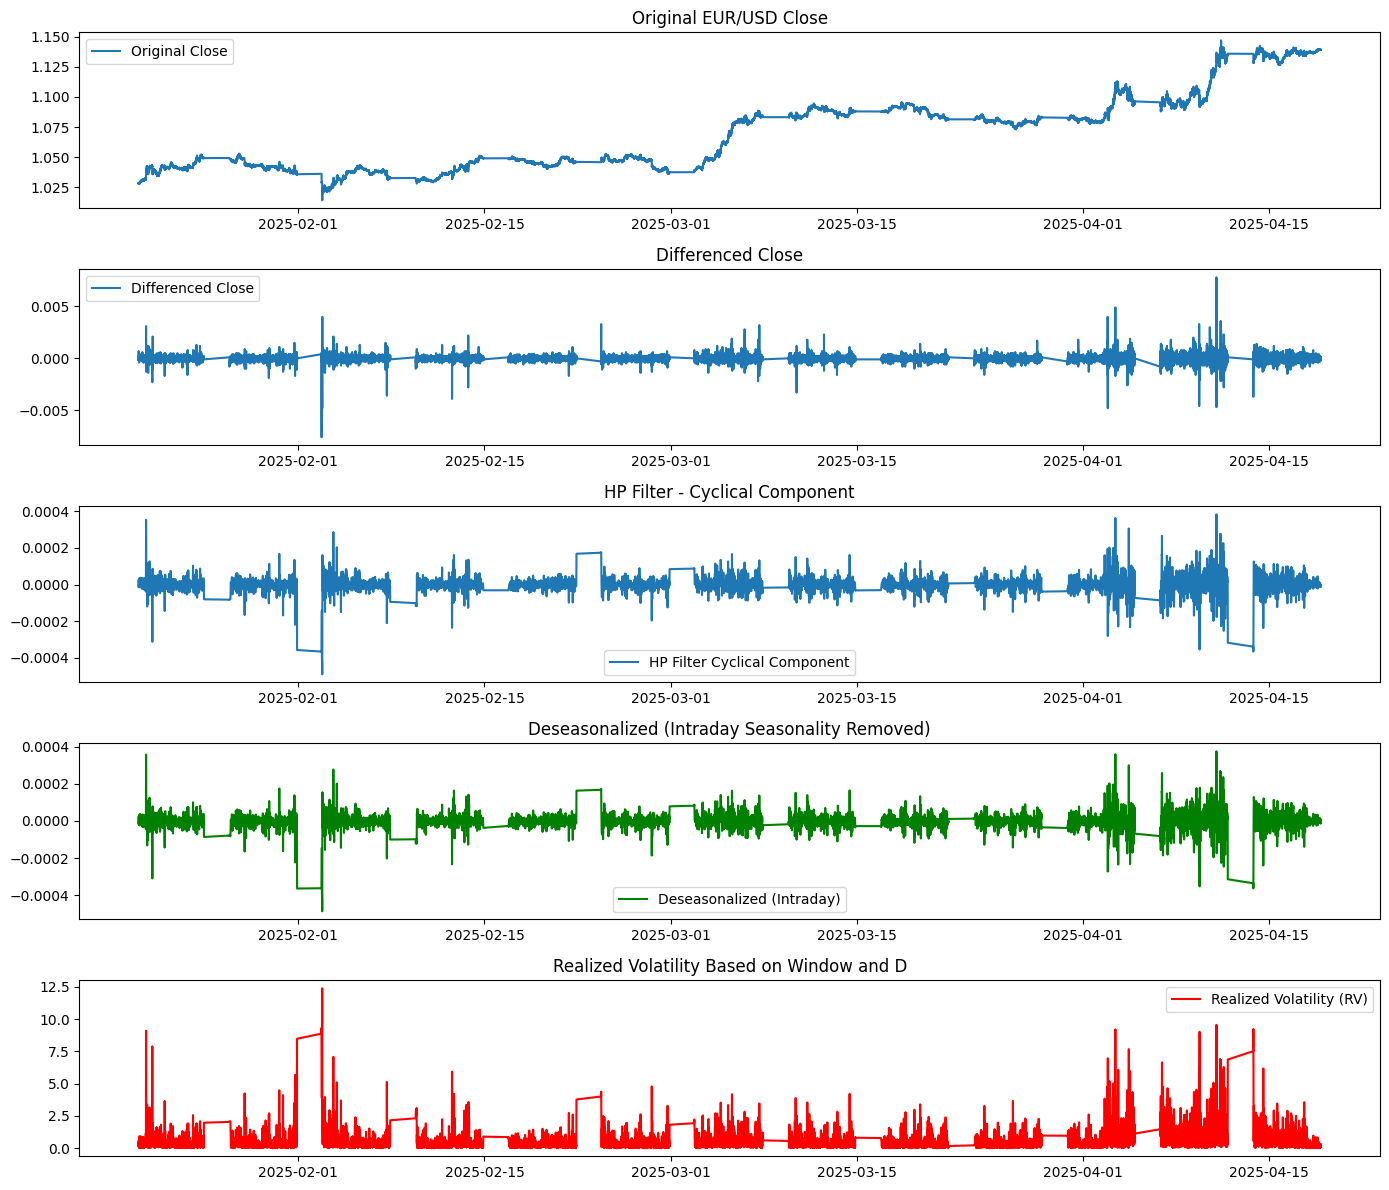

In [25]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.filters.hp_filter import hpfilter

# STEP 0: Load data and ensure 'Close' has a datetime index
sp = pd.read_csv("Eurousd.csv", parse_dates=['Date'], index_col='Date')  # Assuming 'Date' column exists
close = sp['Close'].dropna()

# STEP 1: Differencing to remove trend
diff_close = close.diff().dropna()

# STEP 2: Apply HP filter to extract trend and cyclical components
trend, cyclical = hpfilter(diff_close, lamb=1600)

# STEP 3: Deseasonalize using intraday seasonal mean removal
def deseasonalize_intraday_returns(df, return_col='returns'):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df['time'] = df.index.time
    seasonal_pattern = df.groupby('time')[return_col].mean()
    df['seasonal_mean'] = df['time'].map(seasonal_pattern)
    df['deseasonalized'] = df[return_col] - df['seasonal_mean']
    return df['deseasonalized']

# Prepare input DataFrame for deseasonalization (fixing the index issue)
returns_df = pd.DataFrame({'returns': cyclical}, index=diff_close.index)
deseasonalized = deseasonalize_intraday_returns(returns_df, return_col='returns')

# Optional: Scaling the deseasonalized data
deseasonalized_scaled = (deseasonalized - deseasonalized.mean()) / deseasonalized.std()

# STEP 4: Calculate Realized Volatility (RV) using window and D (sampling interval)
D = 5  # Interval size (e.g., 5-minute returns)
window = 5  # Rolling window size for volatility calculation

# Calculate the squared returns (returns^2)
squared_returns = deseasonalized_scaled ** 2

# Calculate Realized Volatility (RV) using a rolling window and D
sp['squared_return'] = squared_returns
sp['realized_vol_D'] = sp['squared_return'].rolling(window=window).sum() / D
sp['realized_vol_D'] = np.sqrt(sp['realized_vol_D'])

# STEP 5: ADF Test function
def run_adf(series, label):
    result = adfuller(series.dropna())
    print(f"ADF Test - {label}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values: {result[4]}")
    print("-" * 50)

# Run ADF tests
run_adf(close, "Original Close")
run_adf(diff_close, "Differenced Close")
run_adf(cyclical, "HP Filter - Cyclical Component")
run_adf(deseasonalized, "Deseasonalized (Intraday Mean Removed)")
run_adf(deseasonalized_scaled, "Scaled Deseasonalized")
run_adf(sp['realized_vol_D'], "Realized Volatility (RV)")

# STEP 6: Plot all components
plt.figure(figsize=(14, 12))

# Plot 1: Original EUR/USD Close
plt.subplot(5, 1, 1)
plt.plot(close, label='Original Close')
plt.title("Original EUR/USD Close")
plt.legend()

# Plot 2: Differenced Close
plt.subplot(5, 1, 2)
plt.plot(diff_close, label='Differenced Close')
plt.title("Differenced Close")
plt.legend()

# Plot 3: HP Filter Cyclical Component
plt.subplot(5, 1, 3)
plt.plot(cyclical, label='HP Filter Cyclical Component')
plt.title("HP Filter - Cyclical Component")
plt.legend()

# Plot 4: Deseasonalized (Intraday Seasonality Removed)
plt.subplot(5, 1, 4)
plt.plot(deseasonalized, label='Deseasonalized (Intraday)', color='green')
plt.title("Deseasonalized (Intraday Seasonality Removed)")
plt.legend()

# Plot 5: Realized Volatility (RV)
plt.subplot(5, 1, 5)
plt.plot(sp['realized_vol_D'], label='Realized Volatility (RV)', color='red')
plt.title("Realized Volatility Based on Window and D")
plt.legend()

plt.tight_layout()
plt.show()


| **Transformation**             | **ADF Statistic** | **p-value** | **Stationary?** | **Notes**                                           |
| ------------------------------ | ----------------- | ----------- | --------------- | --------------------------------------------------- |
| Original Close                 | -0.0097           | 0.9577      | ❌ No            | Strong trend; not suitable for modeling as-is       |
| Differenced Close              | -37.4722          | 0.0000      | ✅ Yes           | First difference removed trend                      |
| HP Filter (Cyclical Component) | -30.4089          | 0.0000      | ✅ Yes           | Short-term cycle is stationary                      |
| Deseasonalized (Intraday Mean) | -31.3547          | 0.0000      | ✅ Yes           | Seasonal pattern removed                            |
| Scaled Deseasonalized          | -31.3547          | 0.0000      | ✅ Yes           | Standardization doesn't affect stationarity         |
| Realized Volatility (RV)       | -21.0397          | 0.0000      | ✅ Yes           | Volatility is stable; ready for volatility modeling |


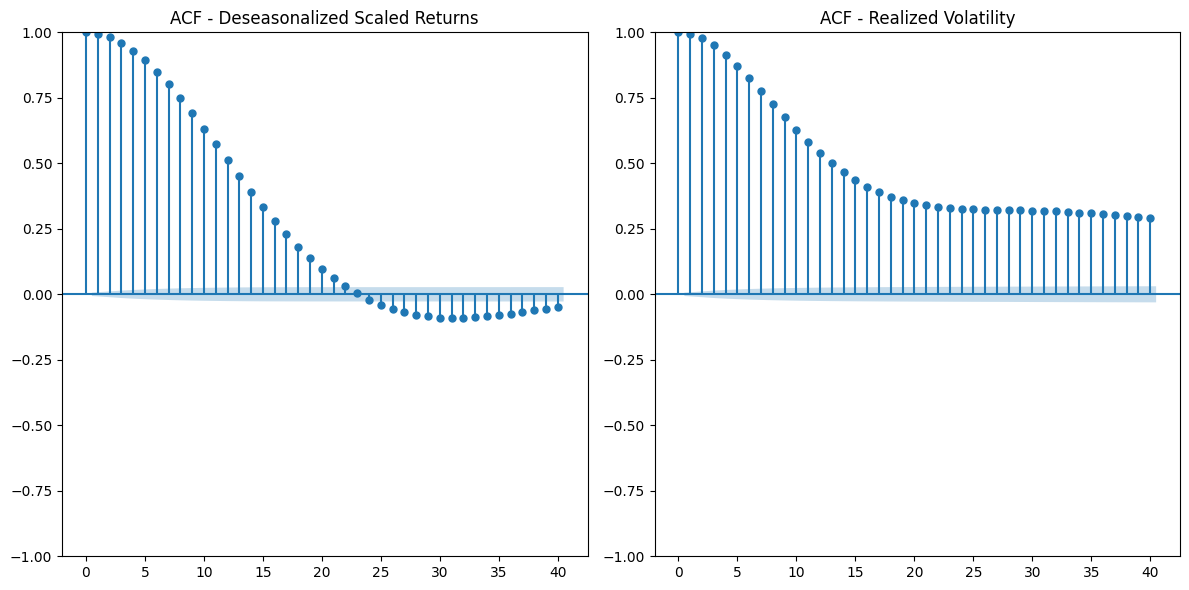

In [26]:
from statsmodels.graphics.tsaplots import plot_acf
# STEP 7: Plot ACF of Deseasonalized Scaled Returns and Realized Volatility
plt.figure(figsize=(12, 6))

# ACF of Deseasonalized Scaled Returns
plt.subplot(1, 2, 1)
plot_acf(deseasonalized_scaled.dropna(), ax=plt.gca(), lags=40)
plt.title("ACF - Deseasonalized Scaled Returns")

# ACF of Realized Volatility
plt.subplot(1, 2, 2)
plot_acf(sp['realized_vol_D'].dropna(), ax=plt.gca(), lags=40)
plt.title("ACF - Realized Volatility")

plt.tight_layout()
plt.show()


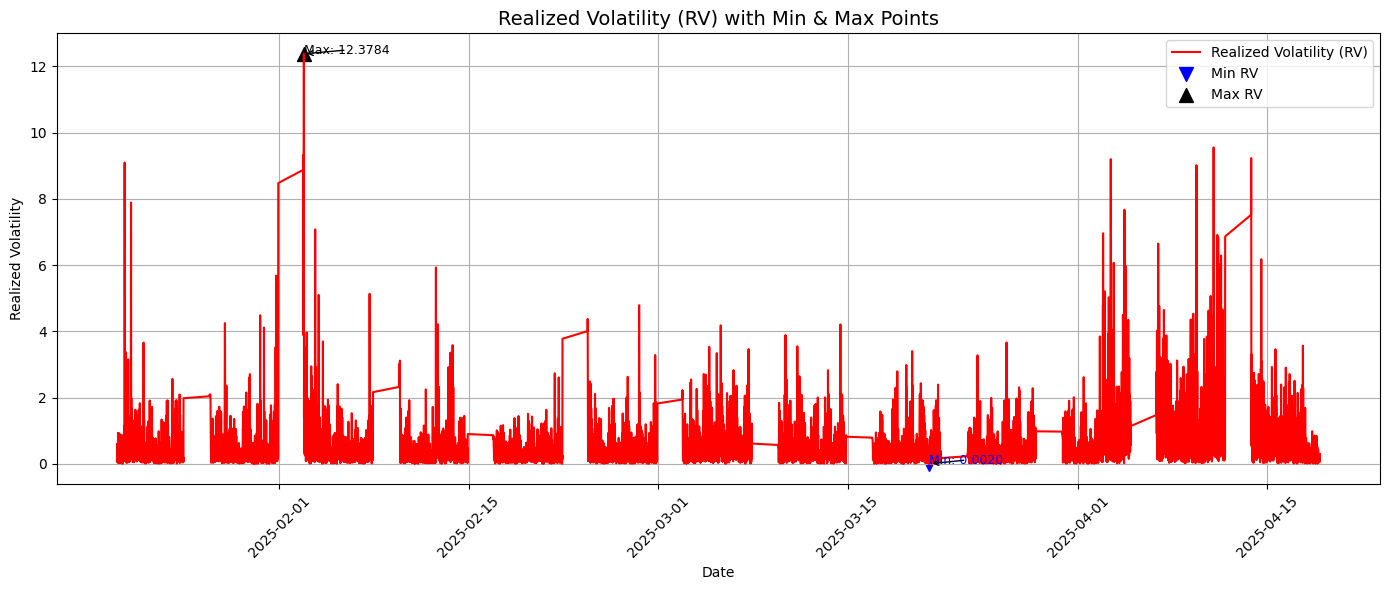

In [27]:
import matplotlib.dates as mdates

# Find index of min and max RV
min_idx = sp['realized_vol_D'].idxmin()
max_idx = sp['realized_vol_D'].idxmax()
min_val = sp['realized_vol_D'].min()
max_val = sp['realized_vol_D'].max()

# Plot the entire RV time series
plt.figure(figsize=(14, 6))
plt.plot(sp['realized_vol_D'], label='Realized Volatility (RV)', color='red', linewidth=1.5)

# Highlight Min and Max points
plt.scatter(min_idx, min_val, color='blue', marker='v', s=100, label='Min RV')
plt.scatter(max_idx, max_val, color='black', marker='^', s=100, label='Max RV')

# Annotate points
plt.annotate(f'Min: {min_val:.4f}',
             xy=(min_idx, min_val),
             xytext=(min_idx, min_val + 0.01),
             textcoords='data',
             arrowprops=dict(facecolor='blue', arrowstyle='->', lw=1),
             fontsize=9,
             color='blue')

plt.annotate(f'Max: {max_val:.4f}',
             xy=(max_idx, max_val),
             xytext=(max_idx, max_val + 0.01),
             textcoords='data',
             arrowprops=dict(facecolor='black', arrowstyle='->', lw=1),
             fontsize=9,
             color='black')

# Improve aesthetics
plt.title("Realized Volatility (RV) with Min & Max Points", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Realized Volatility")
plt.legend()
plt.grid(True)

# Improve x-axis formatting
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


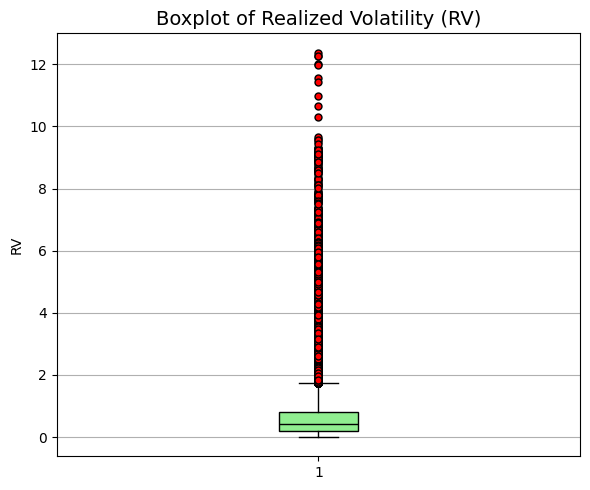

In [28]:
plt.figure(figsize=(6, 5))
plt.boxplot(sp['realized_vol_D'].dropna(), vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=5, linestyle='none'))

plt.title('Boxplot of Realized Volatility (RV)', fontsize=14)
plt.ylabel('RV')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


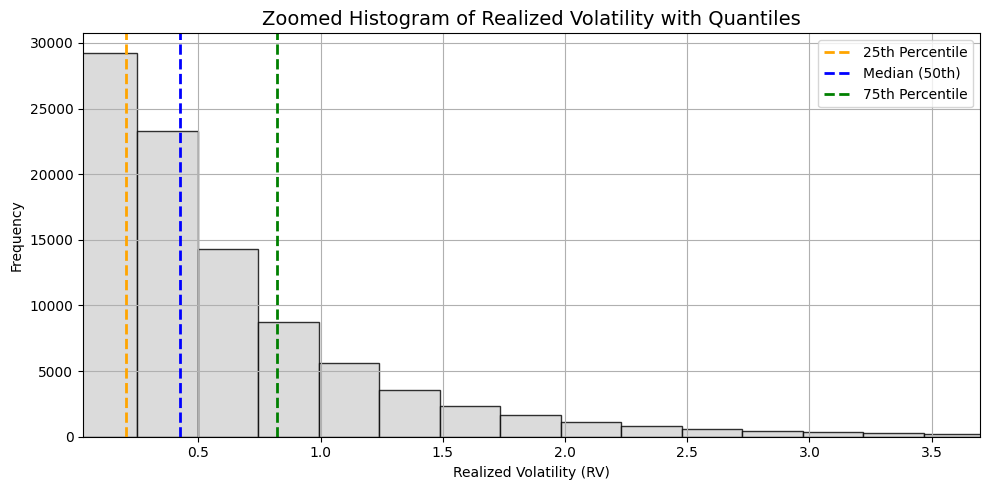

In [29]:
import matplotlib.pyplot as plt

# Drop NaNs from the RV series
rv_data = sp['realized_vol_D'].dropna()

# Compute quantiles
q1 = rv_data.quantile(0.01)
q25 = rv_data.quantile(0.25)
q50 = rv_data.quantile(0.50)
q75 = rv_data.quantile(0.75)
q99 = rv_data.quantile(0.99)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(rv_data, bins=50, color='lightgray', edgecolor='black', alpha=0.8)

# Overlay quantile lines
plt.axvline(q25, color='orange', linestyle='--', linewidth=2, label='25th Percentile')
plt.axvline(q50, color='blue', linestyle='--', linewidth=2, label='Median (50th)')
plt.axvline(q75, color='green', linestyle='--', linewidth=2, label='75th Percentile')

# Zoom into 1st to 99th percentile range
plt.xlim(q1, q99)

# Titles and labels
plt.title('Zoomed Histogram of Realized Volatility with Quantiles', fontsize=14)
plt.xlabel('Realized Volatility (RV)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


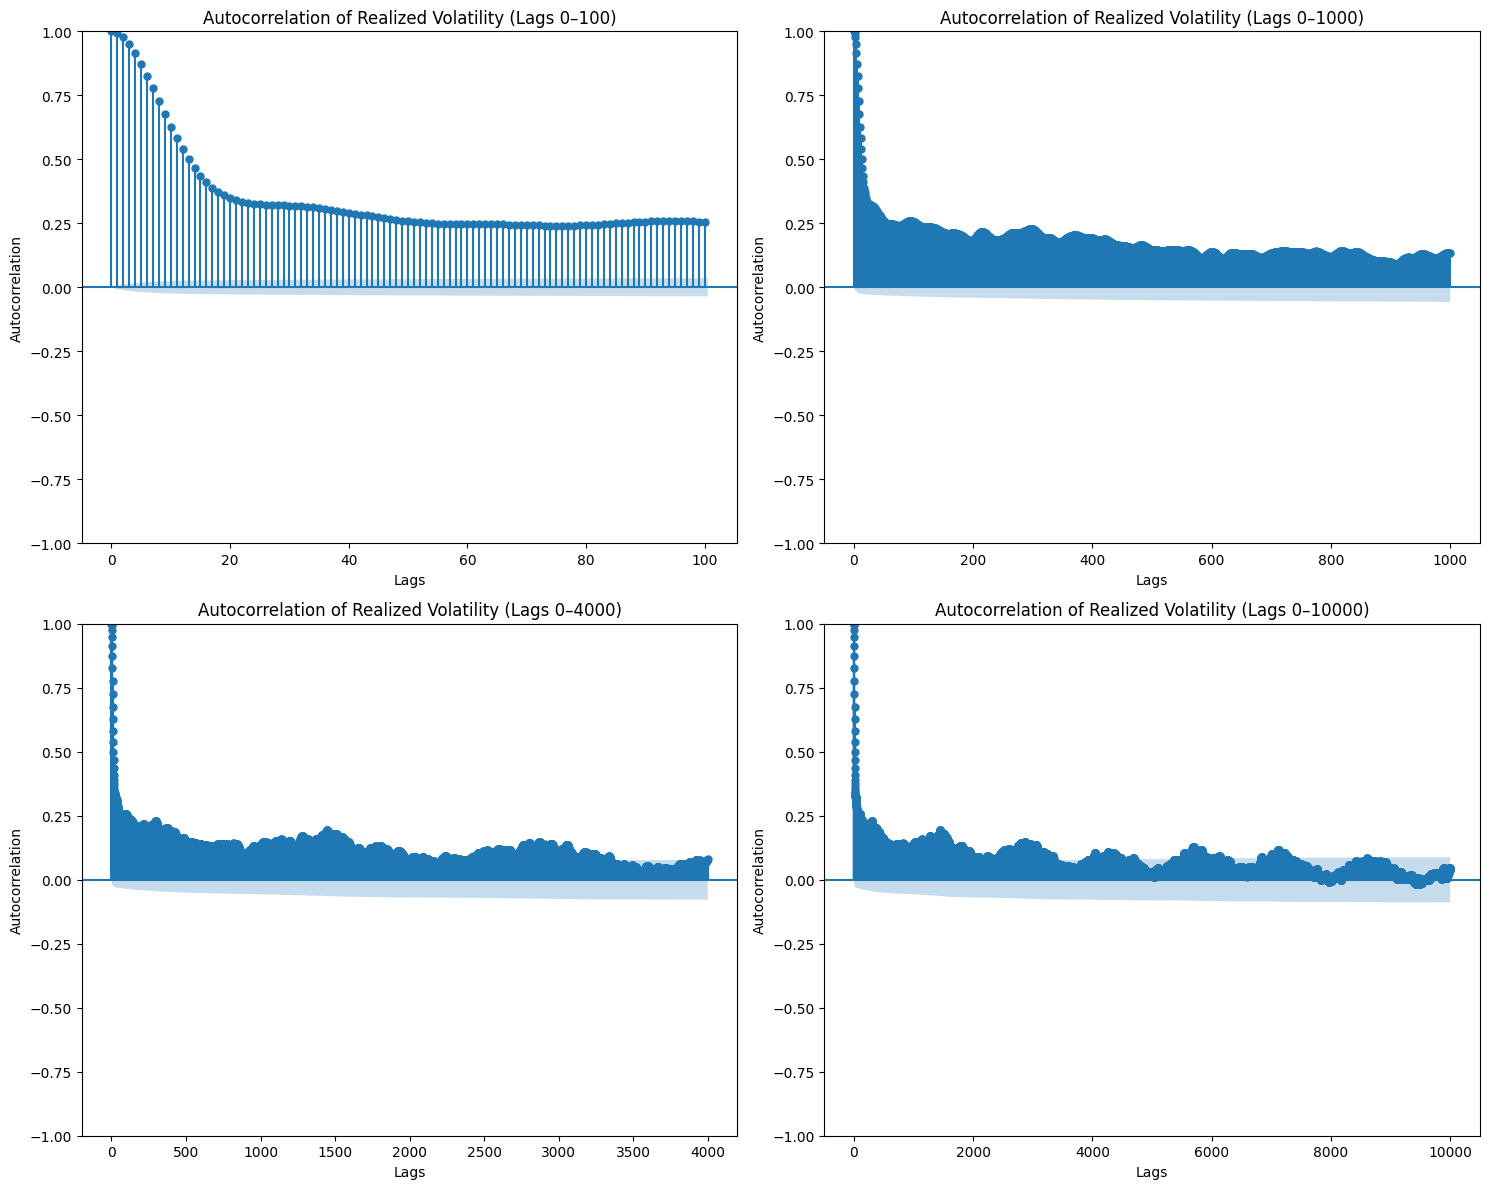

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Drop NaN values from the realized_vol_D column
sp_cleaned = sp.dropna(subset=['realized_vol_D'])

# Create subplots for different lags
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Autocorrelation for lags 0 to 100
plot_acf(sp_cleaned['realized_vol_D'], lags=range(0, 101), ax=axes[0, 0], alpha=0.05)
axes[0, 0].set_title('Autocorrelation of Realized Volatility (Lags 0–100)')
axes[0, 0].set_xlabel('Lags')
axes[0, 0].set_ylabel('Autocorrelation')

# Plot 2: Autocorrelation for lags 0 to 1000
plot_acf(sp_cleaned['realized_vol_D'], lags=range(0, 1001), ax=axes[0, 1], alpha=0.05)
axes[0, 1].set_title('Autocorrelation of Realized Volatility (Lags 0–1000)')
axes[0, 1].set_xlabel('Lags')
axes[0, 1].set_ylabel('Autocorrelation')

# Plot 3: Autocorrelation for lags 0 to 4000
plot_acf(sp_cleaned['realized_vol_D'], lags=range(0, 4001), ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('Autocorrelation of Realized Volatility (Lags 0–4000)')
axes[1, 0].set_xlabel('Lags')
axes[1, 0].set_ylabel('Autocorrelation')

# Plot 4: Autocorrelation for lags 0 to 10000
plot_acf(sp_cleaned['realized_vol_D'], lags=range(0, 10001), ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('Autocorrelation of Realized Volatility (Lags 0–10000)')
axes[1, 1].set_xlabel('Lags')
axes[1, 1].set_ylabel('Autocorrelation')

# Layout adjustment
plt.tight_layout()
plt.show()


               lb_stat    lb_pvalue
1     92544.1607097487 0.0000000000
2    181975.1355171633 0.0000000000
3    266558.8248795982 0.0000000000
4    344979.5265893777 0.0000000000
5    416383.2272255628 0.0000000000
..                 ...          ...
96  1375290.1866232797 0.0000000000
97  1381532.4079131470 0.0000000000
98  1387745.4442762460 0.0000000000
99  1393919.6465441964 0.0000000000
100 1400046.1188686928 0.0000000000

[100 rows x 2 columns]


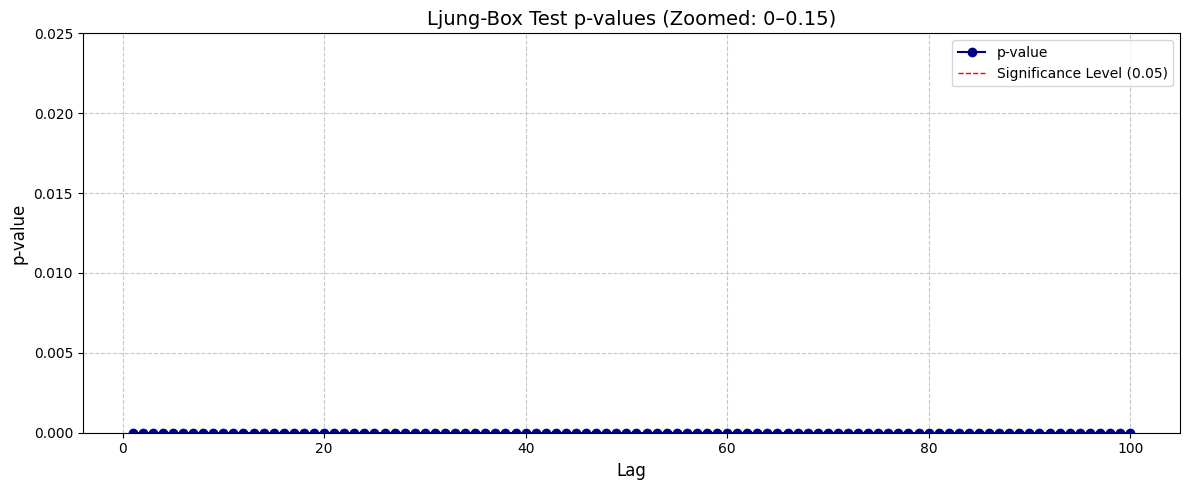

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox

# Clean the data
rv_data = sp['realized_vol_D'].dropna()

# Run Ljung-Box test for lags 1 to 100
lb_test_vol = acorr_ljungbox(rv_data, lags=range(1, 101), return_df=True)

# Set display format
pd.set_option('display.float_format', '{:.10f}'.format)
print(lb_test_vol)

# Plot p-values with better zoom
plt.figure(figsize=(12, 5))
plt.plot(lb_test_vol.index, lb_test_vol['lb_pvalue'], marker='o', linestyle='-', color='navy', label='p-value')

# Add significance threshold line at 0.05
plt.axhline(y=0.05, color='red', linestyle='--', linewidth=1, label='Significance Level (0.05)')

# Improved Zoom: Show range from 0 to 0.15
plt.ylim(0, 0.025)

# Plot styling
plt.title('Ljung-Box Test p-values (Zoomed: 0–0.15)', fontsize=14)
plt.xlabel('Lag', fontsize=12)
plt.ylabel('p-value', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


                 Date         Open         High          Low        Close  \
2 2025-01-20 00:03:00 1.0282000000 1.0282000000 1.0279000000 1.0279000000   
3 2025-01-20 00:04:00 1.0279000000 1.0279000000 1.0277000000 1.0277000000   
4 2025-01-20 00:05:00 1.0277000000 1.0279000000 1.0277000000 1.0278000000   
5 2025-01-20 00:06:00 1.0278000000 1.0281000000 1.0278000000 1.0280000000   
6 2025-01-20 00:07:00 1.0280000000 1.0282000000 1.0279000000 1.0282000000   

     log_return  
2 -0.0001945525  
3 -0.0001945904  
4  0.0000972999  
5  0.0001945715  
6  0.0001945336  


,Date,Open,High,Low,Close,log_return
2,2025-01-20 00:03:00,1.0282000000,1.0282000000,1.0279000000,1.0279000000,NaN
3,2025-01-20 00:04:00,1.0279000000,1.0279000000,1.0277000000,1.0277000000,-0.0001945904
4,2025-01-20 00:05:00,1.0277000000,1.0279000000,1.0277000000,1.0278000000,0.0000972999
5,2025-01-20 00:06:00,1.0278000000,1.0281000000,1.0278000000,1.0280000000,0.0001945715
6,2025-01-20 00:07:00,1.0280000000,1.0282000000,1.0279000000,1.0282000000,0.0001945336
...,...,...,...,...,...,...
93619,2025-04-18 20:51:00,1.1391000000,1.1391000000,1.1390000000,1.1391000000,0.0000000000
93620,2025-04-18 20:52:00,1.1391000000,1.1392000000,1.1391000000,1.1392000000,0.0000877848
93621,2025-04-18 20:53:00,1.1392000000,1.1393000000,1.1392000000,1.1392000000,0.0000000000
93622,2025-04-18 20:54:00,1.1392000000,1.1392000000,1.1392000000,1.1392000000,0.0000000000


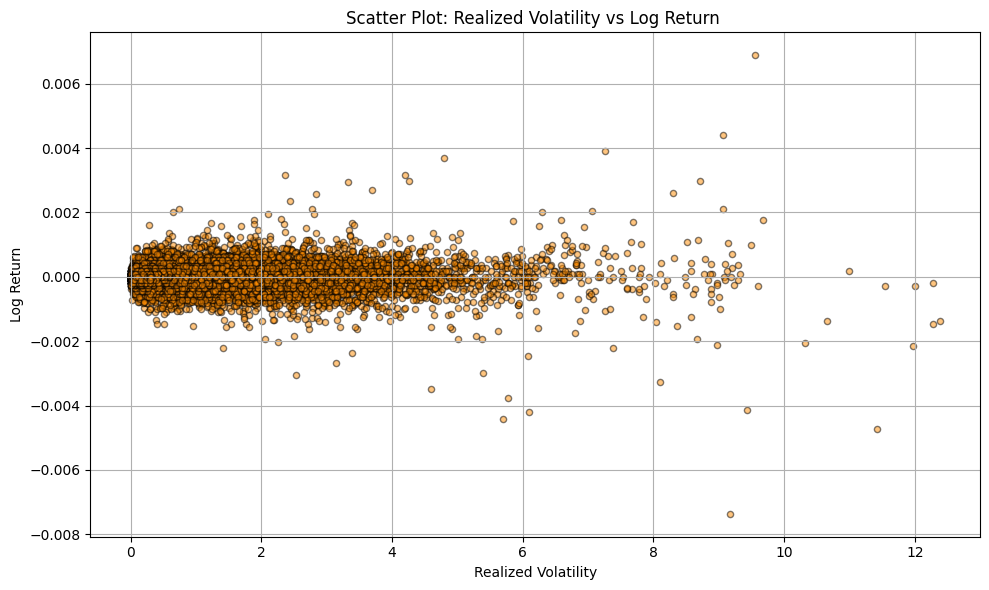

In [33]:
import matplotlib.pyplot as plt

# Ensure no NaNs in the relevant columns
# Calculate log returns and add to DataFrame
sp['log_return'] = np.log(sp['Close'] / sp['Close'].shift(1))

vol_log_df = sp[['realized_vol_D', 'log_return']].dropna()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(vol_log_df['realized_vol_D'], vol_log_df['log_return'],
            alpha=0.5, color='darkorange', edgecolor='k', s=20)

plt.title('Scatter Plot: Realized Volatility vs Log Return ')
plt.xlabel('Realized Volatility')
plt.ylabel('Log Return')
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-36-d71fb1cbca93>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp['log_return'] = np.log(sp['Close'] / sp['Close'].shift(1))


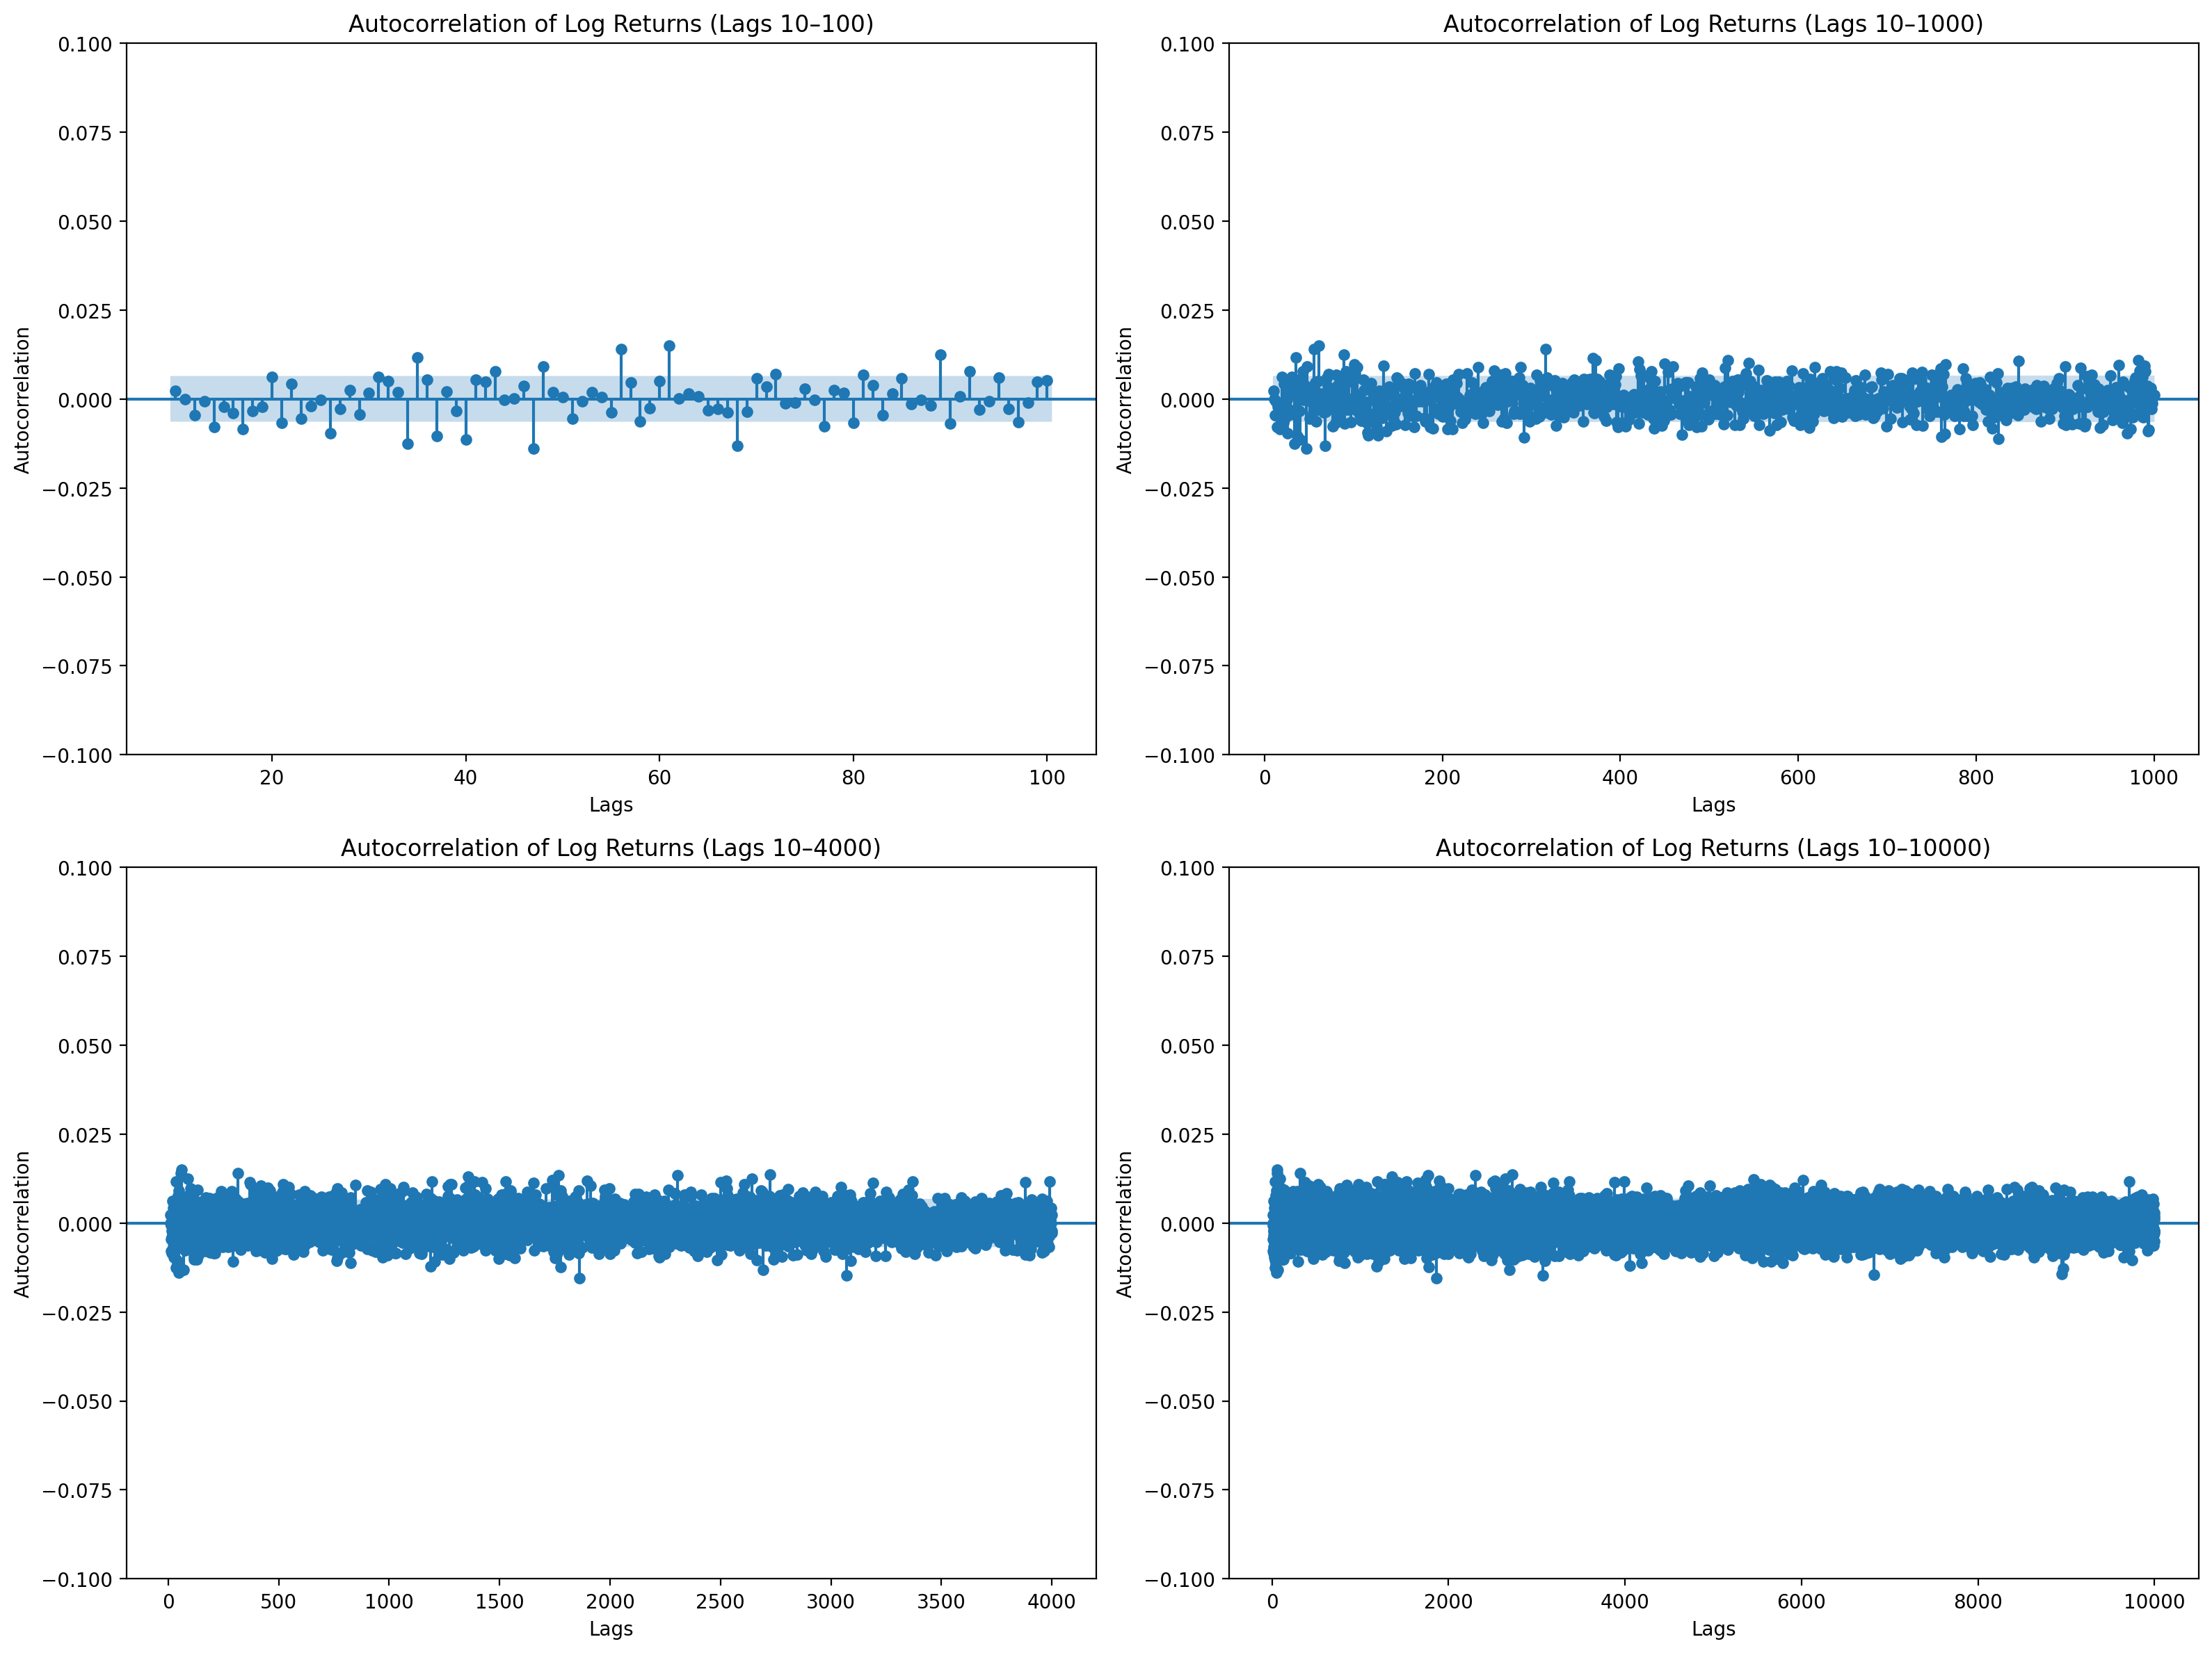


Ljung-Box Test Results (lag 20):
          lb_stat    lb_pvalue
20 315.3101622538 0.0000000000

Ljung-Box Test Results (lag 100):
           lb_stat    lb_pvalue
100 578.7269846709 0.0000000000

Ljung-Box Test Results (lag 1000):
             lb_stat    lb_pvalue
1000 2091.8048964745 0.0000000000

Ljung-Box Test Results (lag 4000):
             lb_stat    lb_pvalue
4000 6336.0786772650 0.0000000000

Ljung-Box Test Results (lag 10000):
               lb_stat    lb_pvalue
10000 13640.8957229218 0.0000000000


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Set inline figure format for better resolution (for Jupyter)
%config InlineBackend.figure_format = 'retina'

# Assuming 'sp' is your DataFrame and it contains a 'Close' price column
# Calculate log returns
sp['log_return'] = np.log(sp['Close'] / sp['Close'].shift(1))
ret = sp['log_return'].dropna()

# Create subplots for multiple ACF plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Autocorrelation for lags 10 to 100
plot_acf(ret, lags=range(10, 101), ax=axes[0, 0], alpha=0.05)
axes[0, 0].set_title('Autocorrelation of Log Returns (Lags 10–100)')
axes[0, 0].set_xlabel('Lags')
axes[0, 0].set_ylabel('Autocorrelation')
axes[0, 0].set_ylim([-0.1, 0.1])

# Plot 2: Autocorrelation for lags 10 to 1000
plot_acf(ret, lags=range(10, 1001), ax=axes[0, 1], alpha=0.05)
axes[0, 1].set_title('Autocorrelation of Log Returns (Lags 10–1000)')
axes[0, 1].set_xlabel('Lags')
axes[0, 1].set_ylabel('Autocorrelation')
axes[0, 1].set_ylim([-0.1, 0.1])

# Plot 3: Autocorrelation for lags 10 to 4000
plot_acf(ret, lags=range(10, 4001), ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('Autocorrelation of Log Returns (Lags 10–4000)')
axes[1, 0].set_xlabel('Lags')
axes[1, 0].set_ylabel('Autocorrelation')
axes[1, 0].set_ylim([-0.1, 0.1])

# Plot 4: Autocorrelation for lags 10 to 10000
plot_acf(ret, lags=range(10, 10001), ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('Autocorrelation of Log Returns (Lags 10–10000)')
axes[1, 1].set_xlabel('Lags')
axes[1, 1].set_ylabel('Autocorrelation')
axes[1, 1].set_ylim([-0.1, 0.1])

# Adjust layout
plt.tight_layout()
plt.show()

# Ljung-Box tests at various lags
ljung_box_results = {
    20: acorr_ljungbox(ret, lags=[20], return_df=True),
    100: acorr_ljungbox(ret, lags=[100], return_df=True),
    1000: acorr_ljungbox(ret, lags=[1000], return_df=True),
    4000: acorr_ljungbox(ret, lags=[4000], return_df=True),
    10000: acorr_ljungbox(ret, lags=[10000], return_df=True)
}

# Display results
for lag, result in ljung_box_results.items():
    print(f"\nLjung-Box Test Results (lag {lag}):")
    print(result)


MAE (Mean Absolute Error): 0.432779
RMSE (Root Mean Squared Error): 0.663913


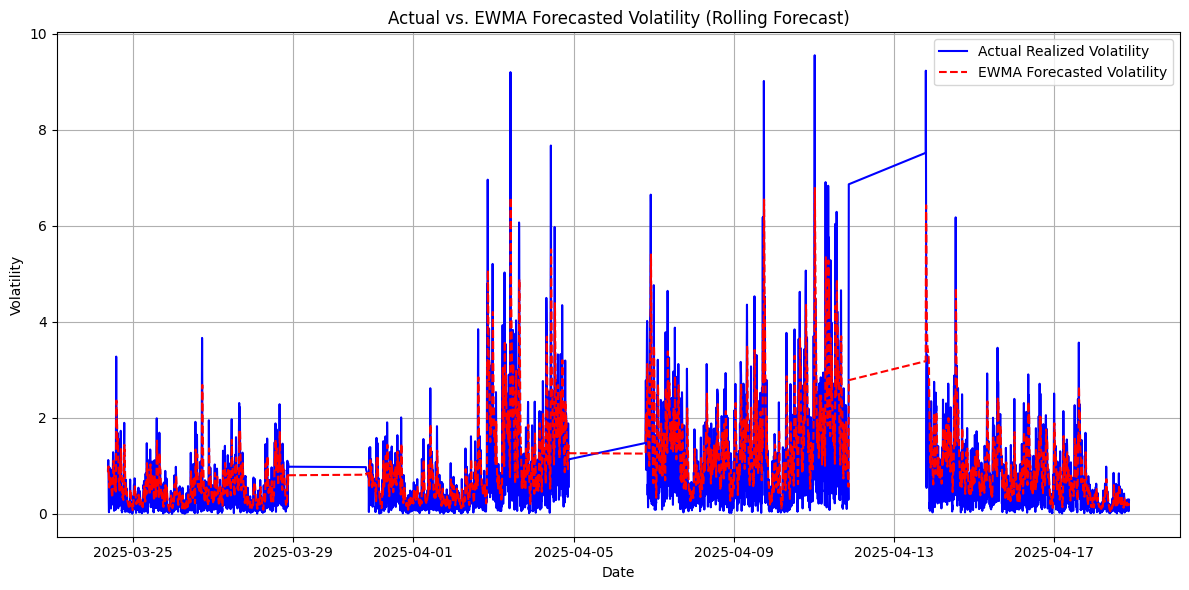

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# EWMA Parameters
lamb = 0.94     # Smoothing parameter
N = 75          # Window size for EWMA
w = (1 - lamb) * lamb ** np.arange(N)[::-1]  # EWMA weights

# Ensure the data doesn't have NaNs before splitting
sp = sp.dropna(subset=['realized_vol_D'])

# Split data into training (70%) and test (30%)
train_data = sp['realized_vol_D'].iloc[:int(len(sp) * 0.7)]
test_data = sp['realized_vol_D'].iloc[int(len(sp) * 0.7):]

# Initialize lists to store forecasted and actual values
forecasted_vol = []
actual_vol = []

# Rolling EWMA Forecast Loop
for i in range(len(test_data)):
    # Ensure we have enough data to forecast
    if len(train_data) < N:
        break

    # Get the last N values from training data
    last_N_data = train_data[-N:]

    # Forecast using EWMA on squared returns (variance)
    forecast_var = np.sum(w * last_N_data**2)
    forecast_vol_val = np.sqrt(forecast_var)

    # Append forecast and actual
    forecasted_vol.append(forecast_vol_val)
    actual_vol.append(test_data.iloc[i])

    # Update training data with the new observed value
    train_data = pd.concat([train_data, test_data.iloc[i:i+1]])

# Convert to Series and align indexes
actual_vol_series = pd.Series(actual_vol, index=test_data.index[:len(actual_vol)])
forecasted_vol_series = pd.Series(forecasted_vol, index=test_data.index[:len(forecasted_vol)])

# Drop any NaNs
valid_idx = (~actual_vol_series.isna()) & (~forecasted_vol_series.isna())
actual_vol_clean = actual_vol_series[valid_idx]
forecasted_vol_clean = forecasted_vol_series[valid_idx]

# Compute error metrics
mae = mean_absolute_error(actual_vol_clean, forecasted_vol_clean)
rmse = np.sqrt(mean_squared_error(actual_vol_clean, forecasted_vol_clean))

# Print MAE and RMSE
print(f"MAE (Mean Absolute Error): {mae:.6f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.6f}")

# Plot actual vs. forecasted volatility
plt.figure(figsize=(12, 6))
plt.plot(actual_vol_clean.index, actual_vol_clean, label='Actual Realized Volatility', color='blue')
plt.plot(forecasted_vol_clean.index, forecasted_vol_clean, label='EWMA Forecasted Volatility', color='red', linestyle='--')

plt.title('Actual vs. EWMA Forecasted Volatility (Rolling Forecast)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


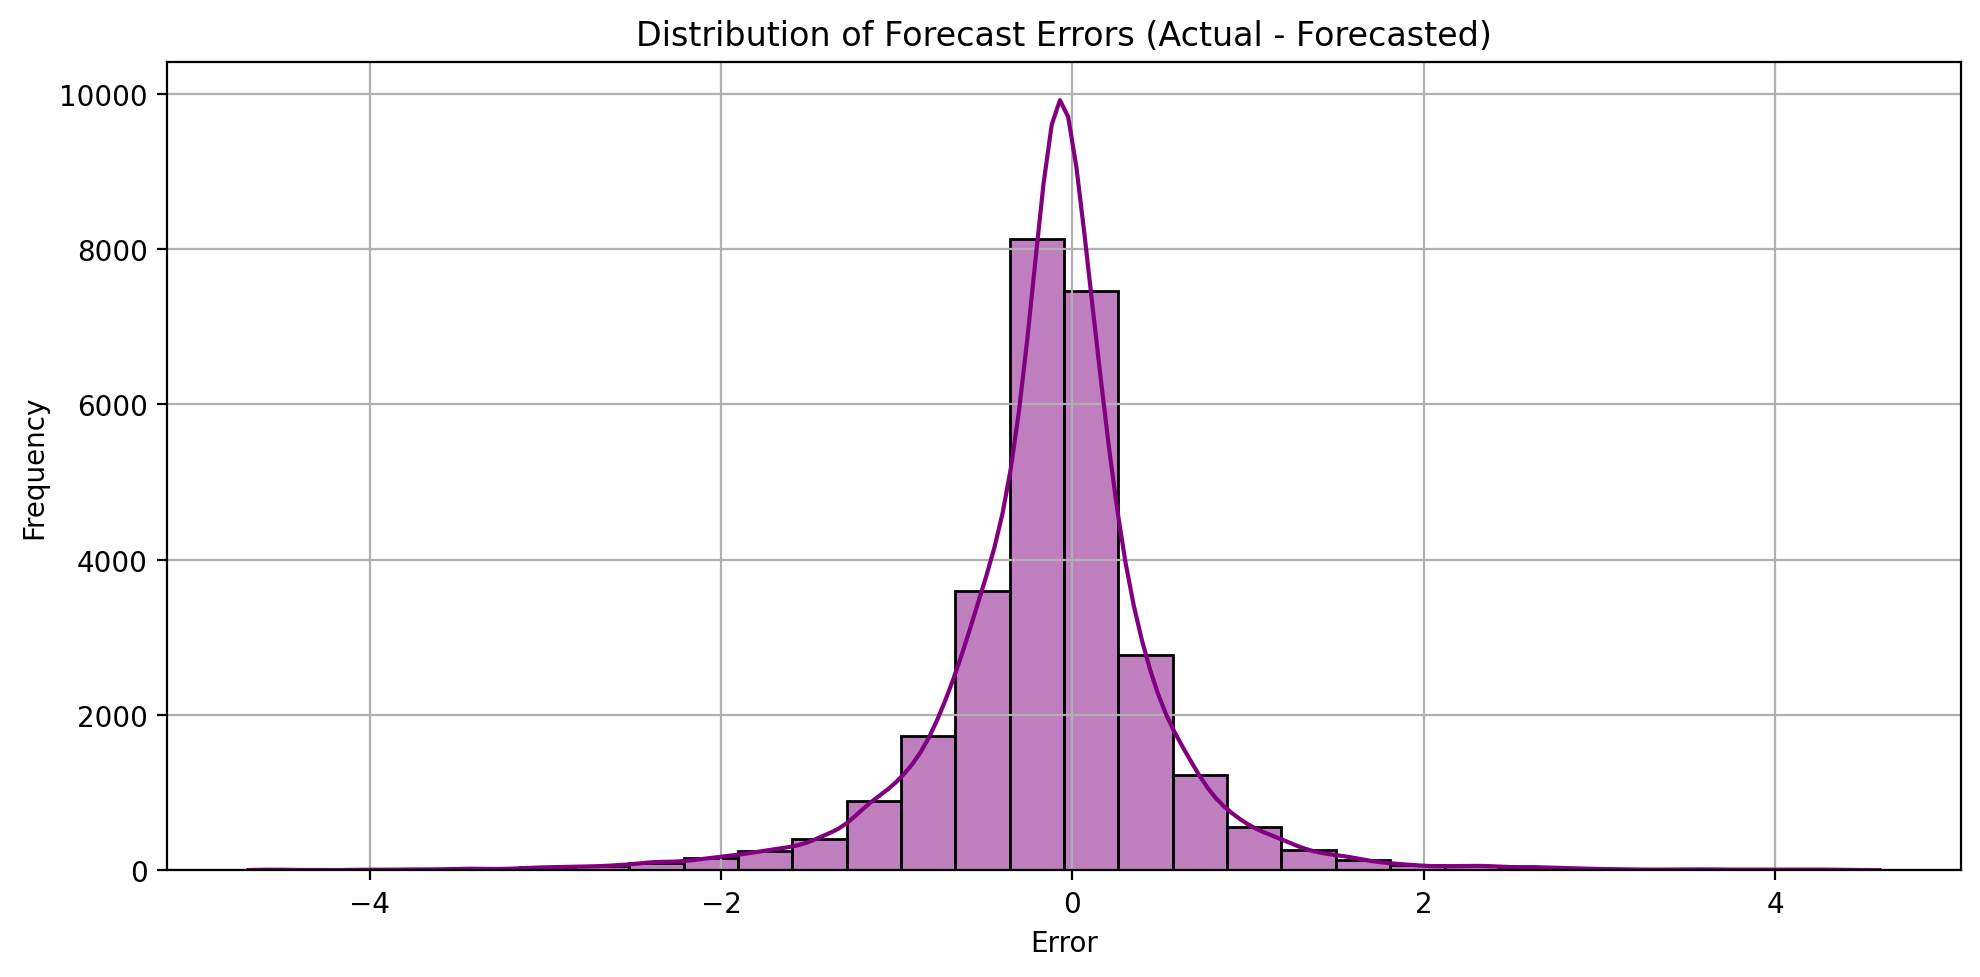

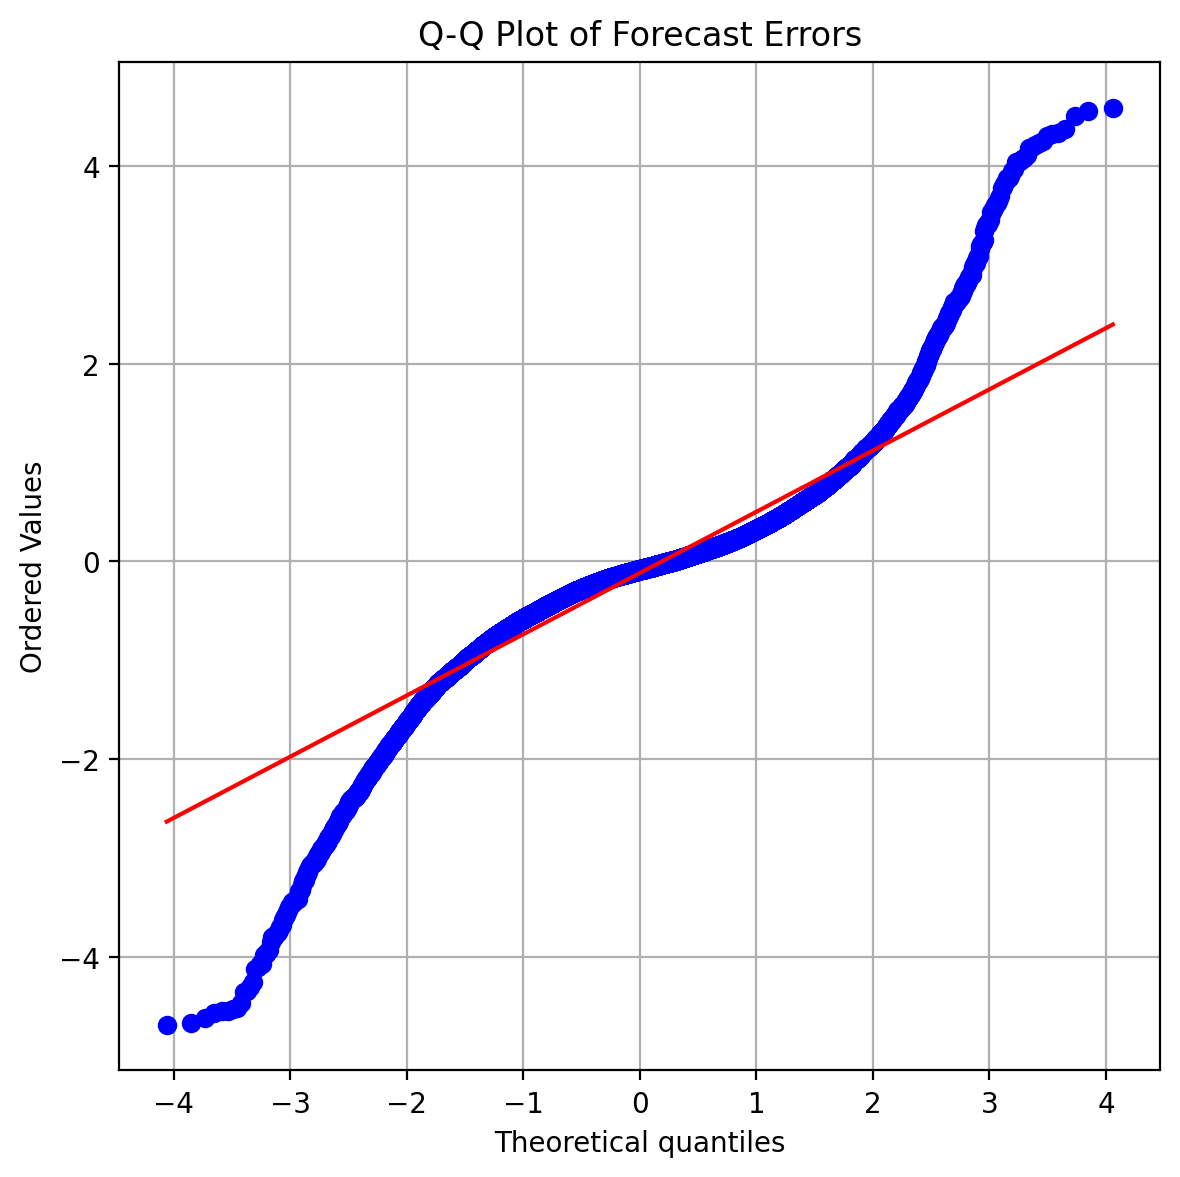

Forecast Error Summary:
count   28086.0000000000
mean       -0.1187933072
std         0.6532100354
min        -4.6890467955
25%        -0.3758614745
50%        -0.0850176633
75%         0.1556303791
max         4.5933211828
dtype: float64


In [37]:
import seaborn as sns
import scipy.stats as stats

# Calculate forecast error (Actual - Forecast)
errors = actual_vol_clean - forecasted_vol_clean

# Plot histogram and KDE of the forecast errors
plt.figure(figsize=(10, 5))
sns.histplot(errors, kde=True, color='purple', bins=30)
plt.title("Distribution of Forecast Errors (Actual - Forecasted)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Q-Q plot to assess normality
plt.figure(figsize=(6, 6))
stats.probplot(errors, dist="norm", plot=plt)
plt.title("Q-Q Plot of Forecast Errors")
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary statistics
print("Forecast Error Summary:")
print(errors.describe())


In [39]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 13.6 MB/s eta 0:00:00


In [40]:
from arch import arch_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Use log returns
ret_pandas = sp['log_return']
realized_vol = sp['realized_vol_D']

# Ensure same length
ret_pandas = ret_pandas.iloc[-len(realized_vol):]
realized_vol = realized_vol.iloc[-len(ret_pandas):]

n = len(ret_pandas)
chunk_size = int(0.2 * n)
forecast_horizon = 1
max_start = n - chunk_size - forecast_horizon

random.seed(42)
start_indices = sorted(random.sample(range(0, max_start), 100))
rmse_list = []

for i, start in enumerate(start_indices):
    ret_chunk = ret_pandas.iloc[start:start + chunk_size]

    am = arch_model(ret_chunk, vol='GARCH', p=1, o=1, q=1, mean='Constant', dist='normal', rescale=True)
    result = am.fit(update_freq=5, disp='off')

    forecast = result.forecast(horizon=forecast_horizon)
    fvol = np.sqrt(forecast.variance.values[-1, :]) / result.scale

    # Actual realized volatility over next forecast_horizon
    actual_vol = realized_vol.iloc[start + chunk_size : start + chunk_size + forecast_horizon].values

    # Ensure shapes match
    if len(actual_vol) == forecast_horizon:
        rmse = np.sqrt(np.mean((actual_vol - fvol) ** 2))
        rmse_list.append((rmse, start))
        print(f"Sample {i+1} (Start Index {start}) - RMSE: {rmse:.4f}")


Sample 1 (Start Index 851) - RMSE: 0.4367
Sample 2 (Start Index 3278) - RMSE: 0.4912
Sample 3 (Start Index 3478) - RMSE: 1.0751
Sample 4 (Start Index 3905) - RMSE: 1.1291
Sample 5 (Start Index 4165) - RMSE: 0.2845
Sample 6 (Start Index 4207) - RMSE: 0.0823
Sample 7 (Start Index 5695) - RMSE: 0.2886
Sample 8 (Start Index 6006) - RMSE: 0.2702
Sample 9 (Start Index 7331) - RMSE: 0.2133
Sample 10 (Start Index 8675) - RMSE: 0.1661
Sample 11 (Start Index 9116) - RMSE: 0.3723
Sample 12 (Start Index 9358) - RMSE: 0.2069
Sample 13 (Start Index 10328) - RMSE: 0.9693
Sample 14 (Start Index 10458) - RMSE: 0.2131
Sample 15 (Start Index 11395) - RMSE: 0.2120
Sample 16 (Start Index 12156) - RMSE: 0.6363
Sample 17 (Start Index 12280) - RMSE: 0.1777
Sample 18 (Start Index 12676) - RMSE: 0.7605
Sample 19 (Start Index 13238) - RMSE: 0.3564
Sample 20 (Start Index 13396) - RMSE: 0.2761
Sample 21 (Start Index 13434) - RMSE: 0.2456
Sample 22 (Start Index 14592) - RMSE: 0.9293
Sample 23 (Start Index 16361) - 

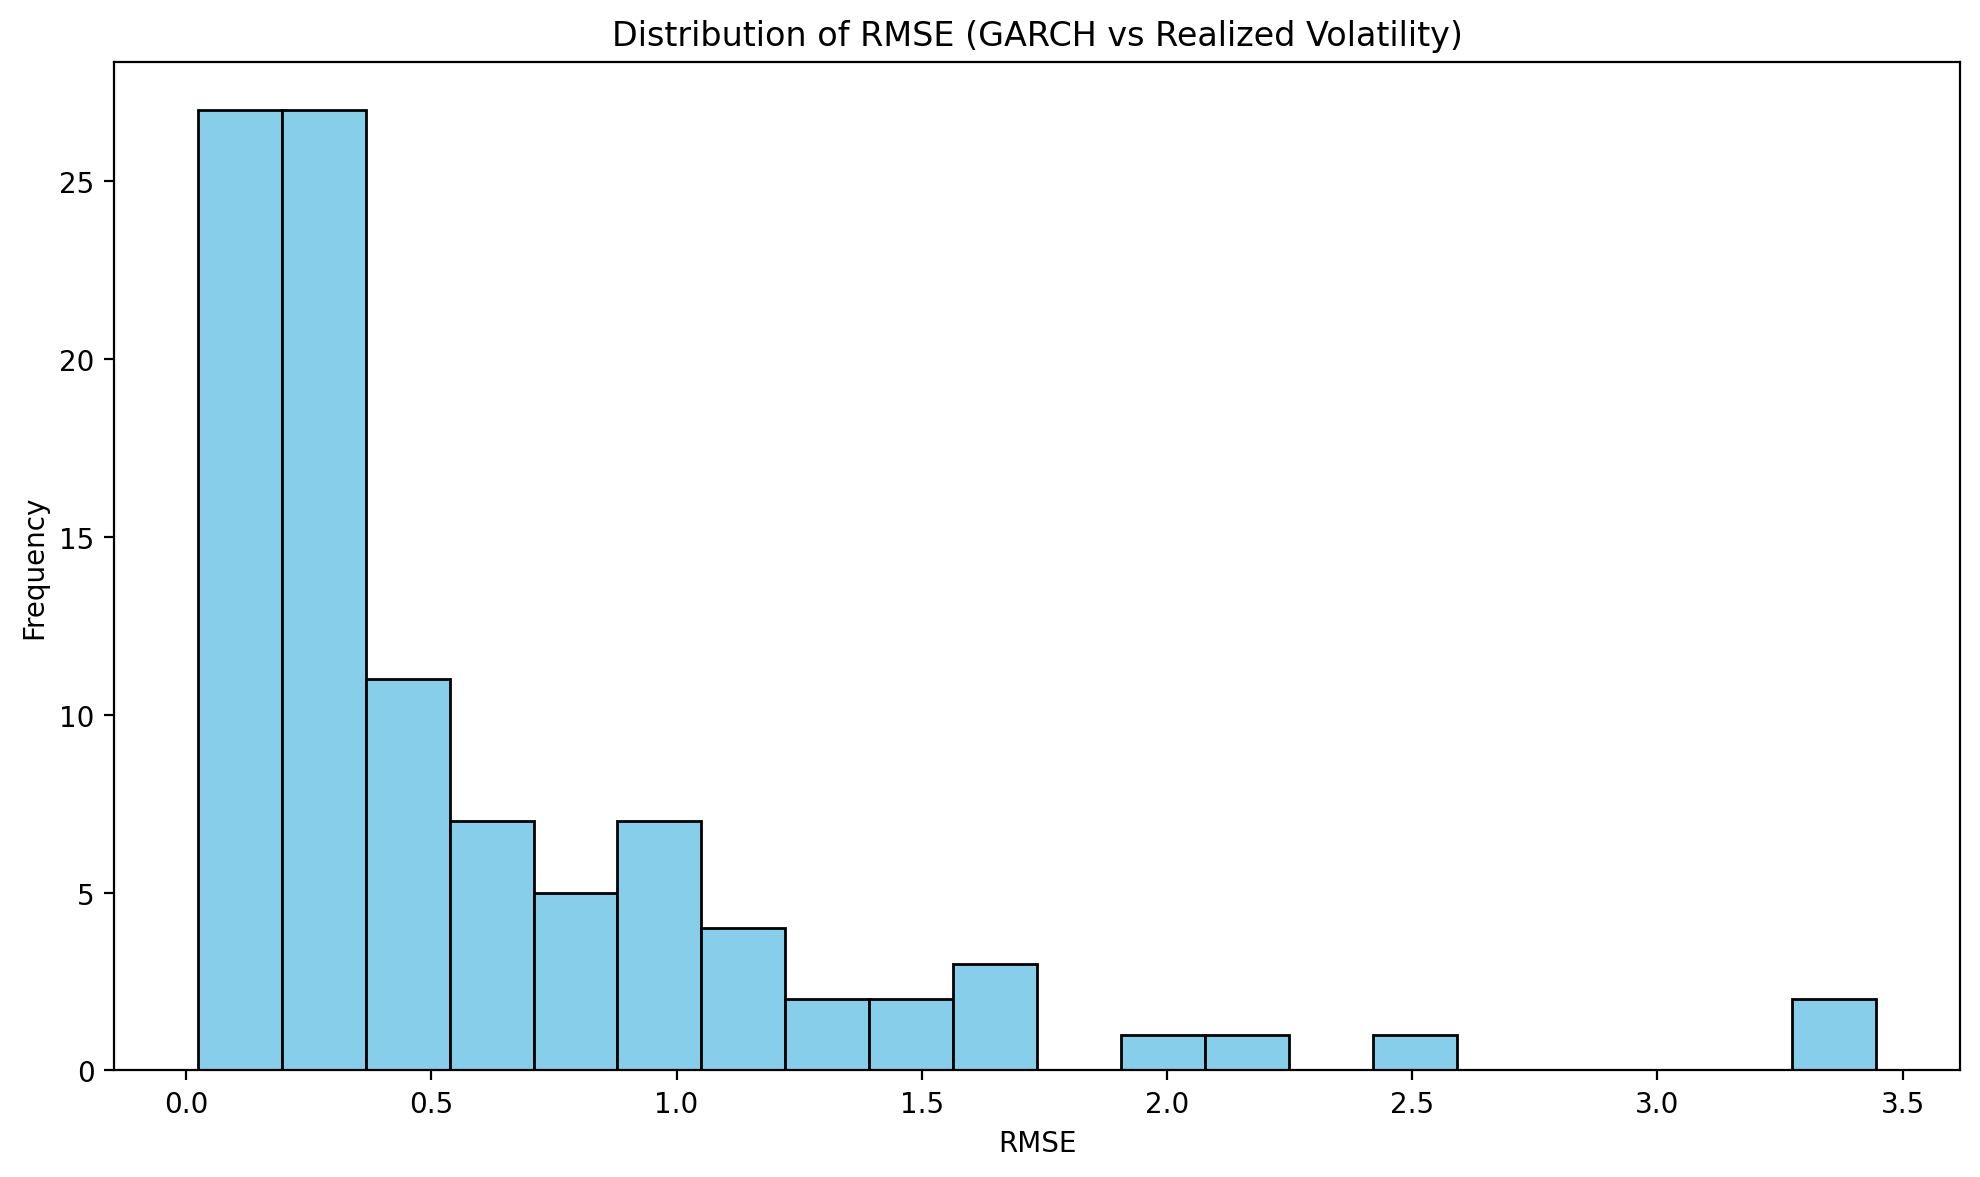

In [43]:
sorted_rmse = sorted(rmse_list, key=lambda x: x[0])
rmse_values = [x[0] for x in sorted_rmse]
plt.figure(figsize=(10, 6))
plt.hist(rmse_values, bins=20, edgecolor='black', color='skyblue')
plt.title('Distribution of RMSE (GARCH vs Realized Volatility)')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


Streaming output truncated to the last 5000 lines.
This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Rolling APARCH Forecasting:  91%|█████████ | 25456/28086 [14:33<01:05, 40.43it/s]/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.152e+07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Rolling APARCH Forecasting:  91%|█████████ | 25461/28086 [14:33<01:08, 38.26it/s]/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scal


Mean Absolute Error (MAE): 0.499340
Root Mean Squared Error (RMSE): 0.710411


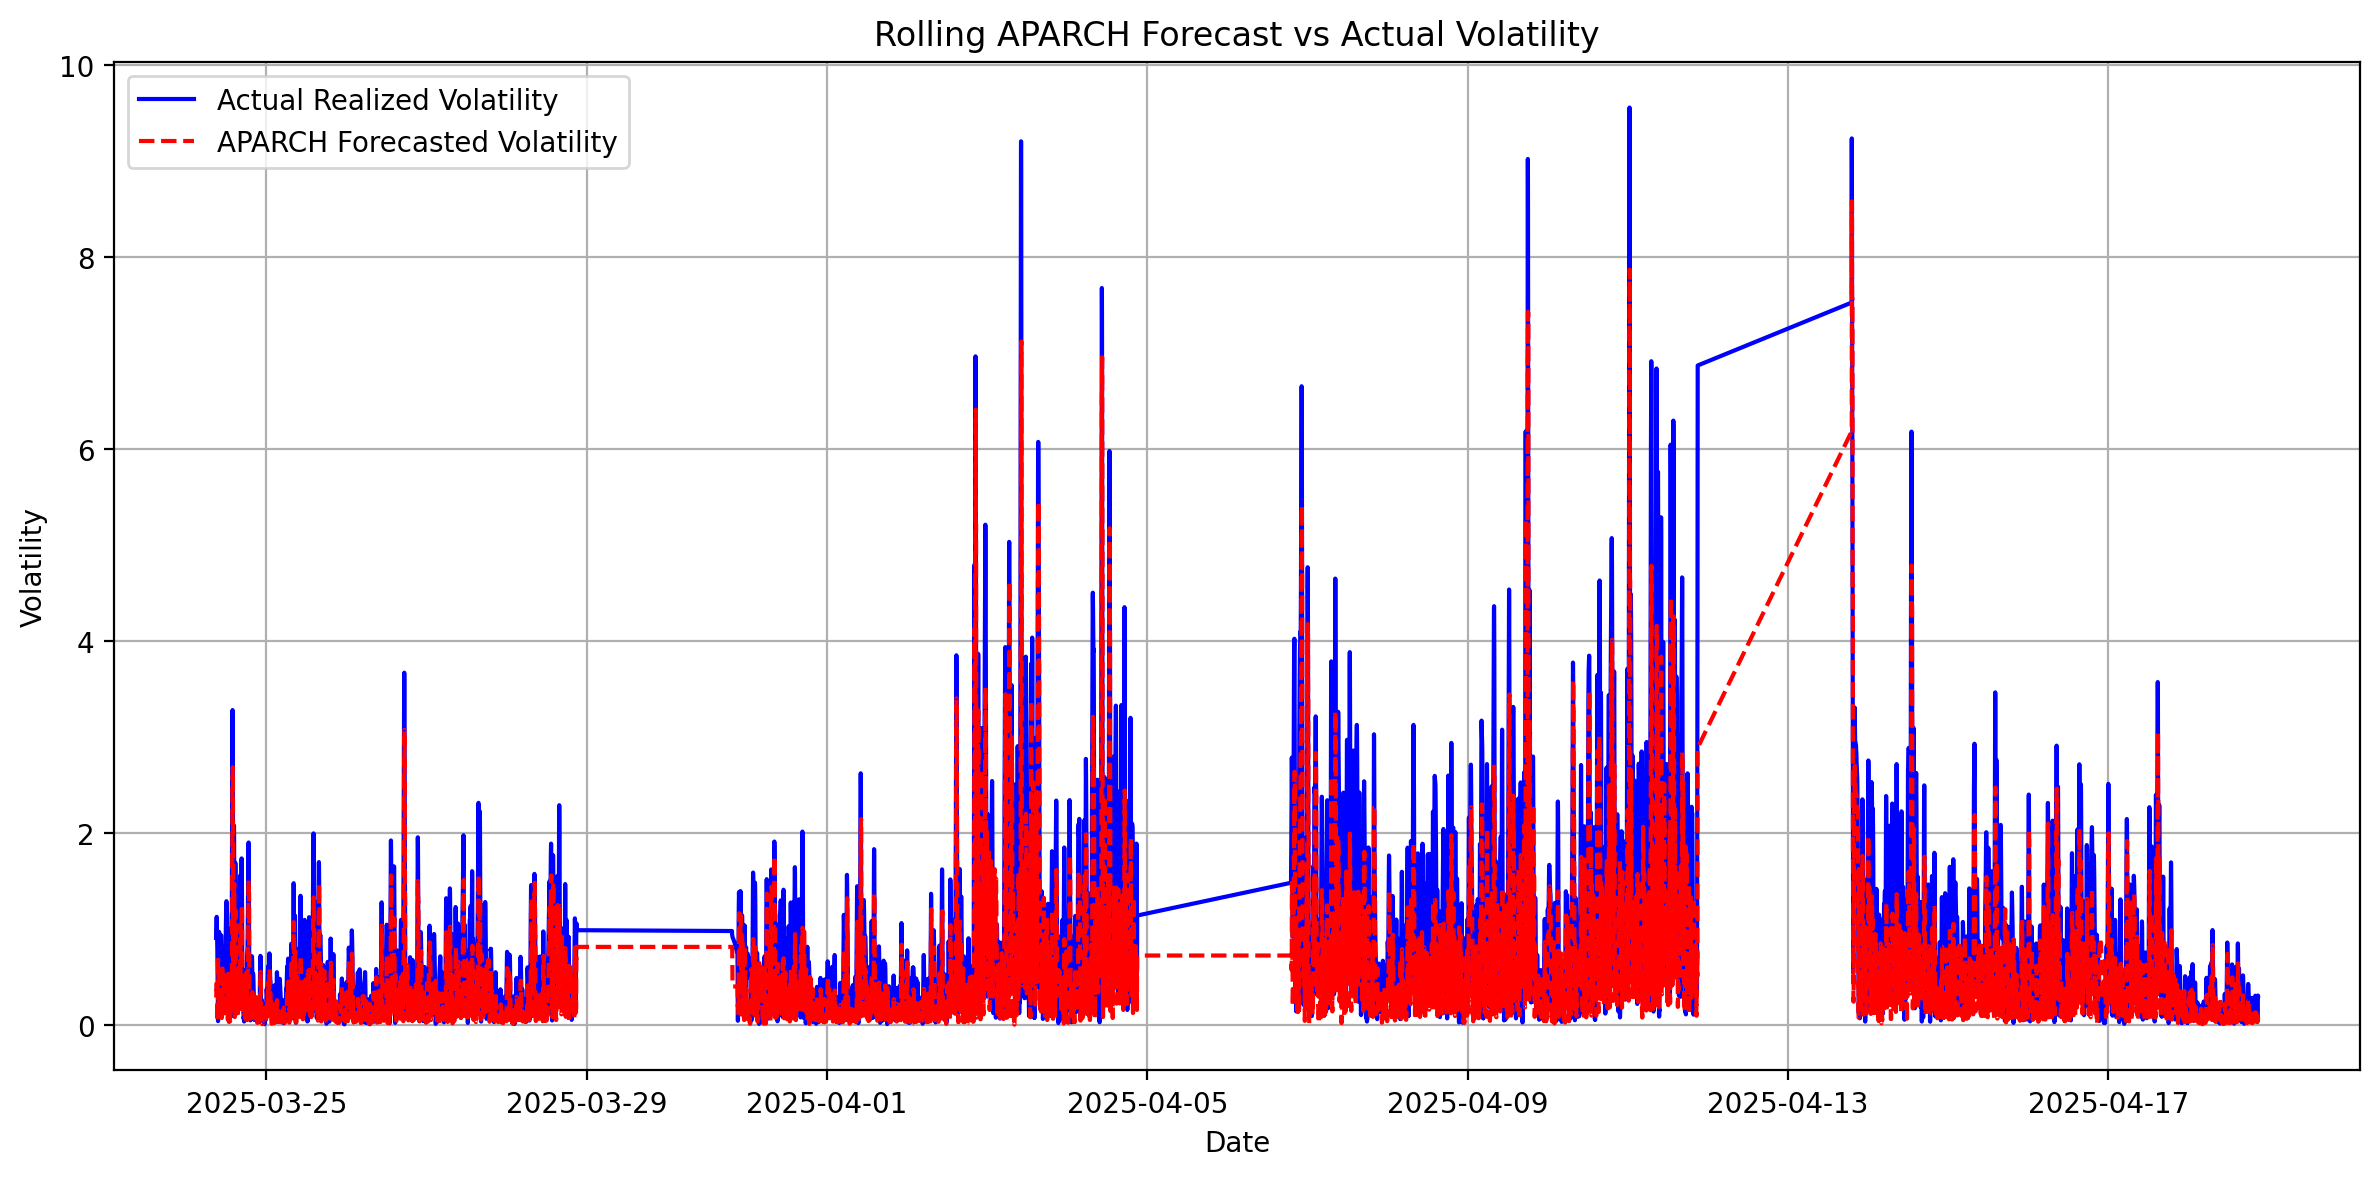

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

# Clean and prepare data
ret_pandas = sp['realized_vol_D'].replace([np.inf, -np.inf], np.nan).dropna()
train_size = int(len(ret_pandas) * 0.7)
train_data = ret_pandas.iloc[:train_size]
test_data = ret_pandas.iloc[train_size:]

# Settings
scale_factor = 1e4
rolling_window_size = 250  # use a fixed-size window
refit_frequency = 5        # refit model every 5 steps

forecasted_vol = []
actual_vol = []
rolling_window = list(train_data[-rolling_window_size:])  # fixed window

# Initial model fit
model = arch_model(np.array(rolling_window) * scale_factor,
                   vol='APARCH', p=1, q=1, power=2.0,
                   mean='Constant', dist='normal')
res = model.fit(disp='off')

for i in tqdm(range(len(test_data)), desc="Rolling APARCH Forecasting"):
    # Refit the model only every `refit_frequency` steps
    if i % refit_frequency == 0:
        model = arch_model(np.array(rolling_window) * scale_factor,
                           vol='APARCH', p=1, q=1, power=2.0,
                           mean='Constant', dist='normal')
        res = model.fit(disp='off')

    # Forecast next day's volatility
    forecast = res.forecast(horizon=1)
    fcast_vol = np.sqrt(forecast.variance.values[-1][0]) / scale_factor
    forecasted_vol.append(fcast_vol)

    # Store actual volatility
    actual_value = test_data.iloc[i]
    actual_vol.append(actual_value)

    # Update the rolling window
    rolling_window.append(actual_value)
    if len(rolling_window) > rolling_window_size:
        rolling_window.pop(0)

# Compute error metrics
mae = mean_absolute_error(actual_vol, forecasted_vol)
rmse = np.sqrt(mean_squared_error(actual_vol, forecasted_vol))

print(f"\nMean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, actual_vol, label='Actual Realized Volatility', color='blue')
plt.plot(test_data.index, forecasted_vol, label='APARCH Forecasted Volatility', color='red', linestyle='--')
plt.title('Rolling APARCH Forecast vs Actual Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Simulating FIE-GARCH Forecasting:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.373e+07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.373e+07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/loca


Mean MAE (FIE-GARCH): 0.407229 ± 0.000000
Mean RMSE (FIE-GARCH): 0.520109 ± 0.000000


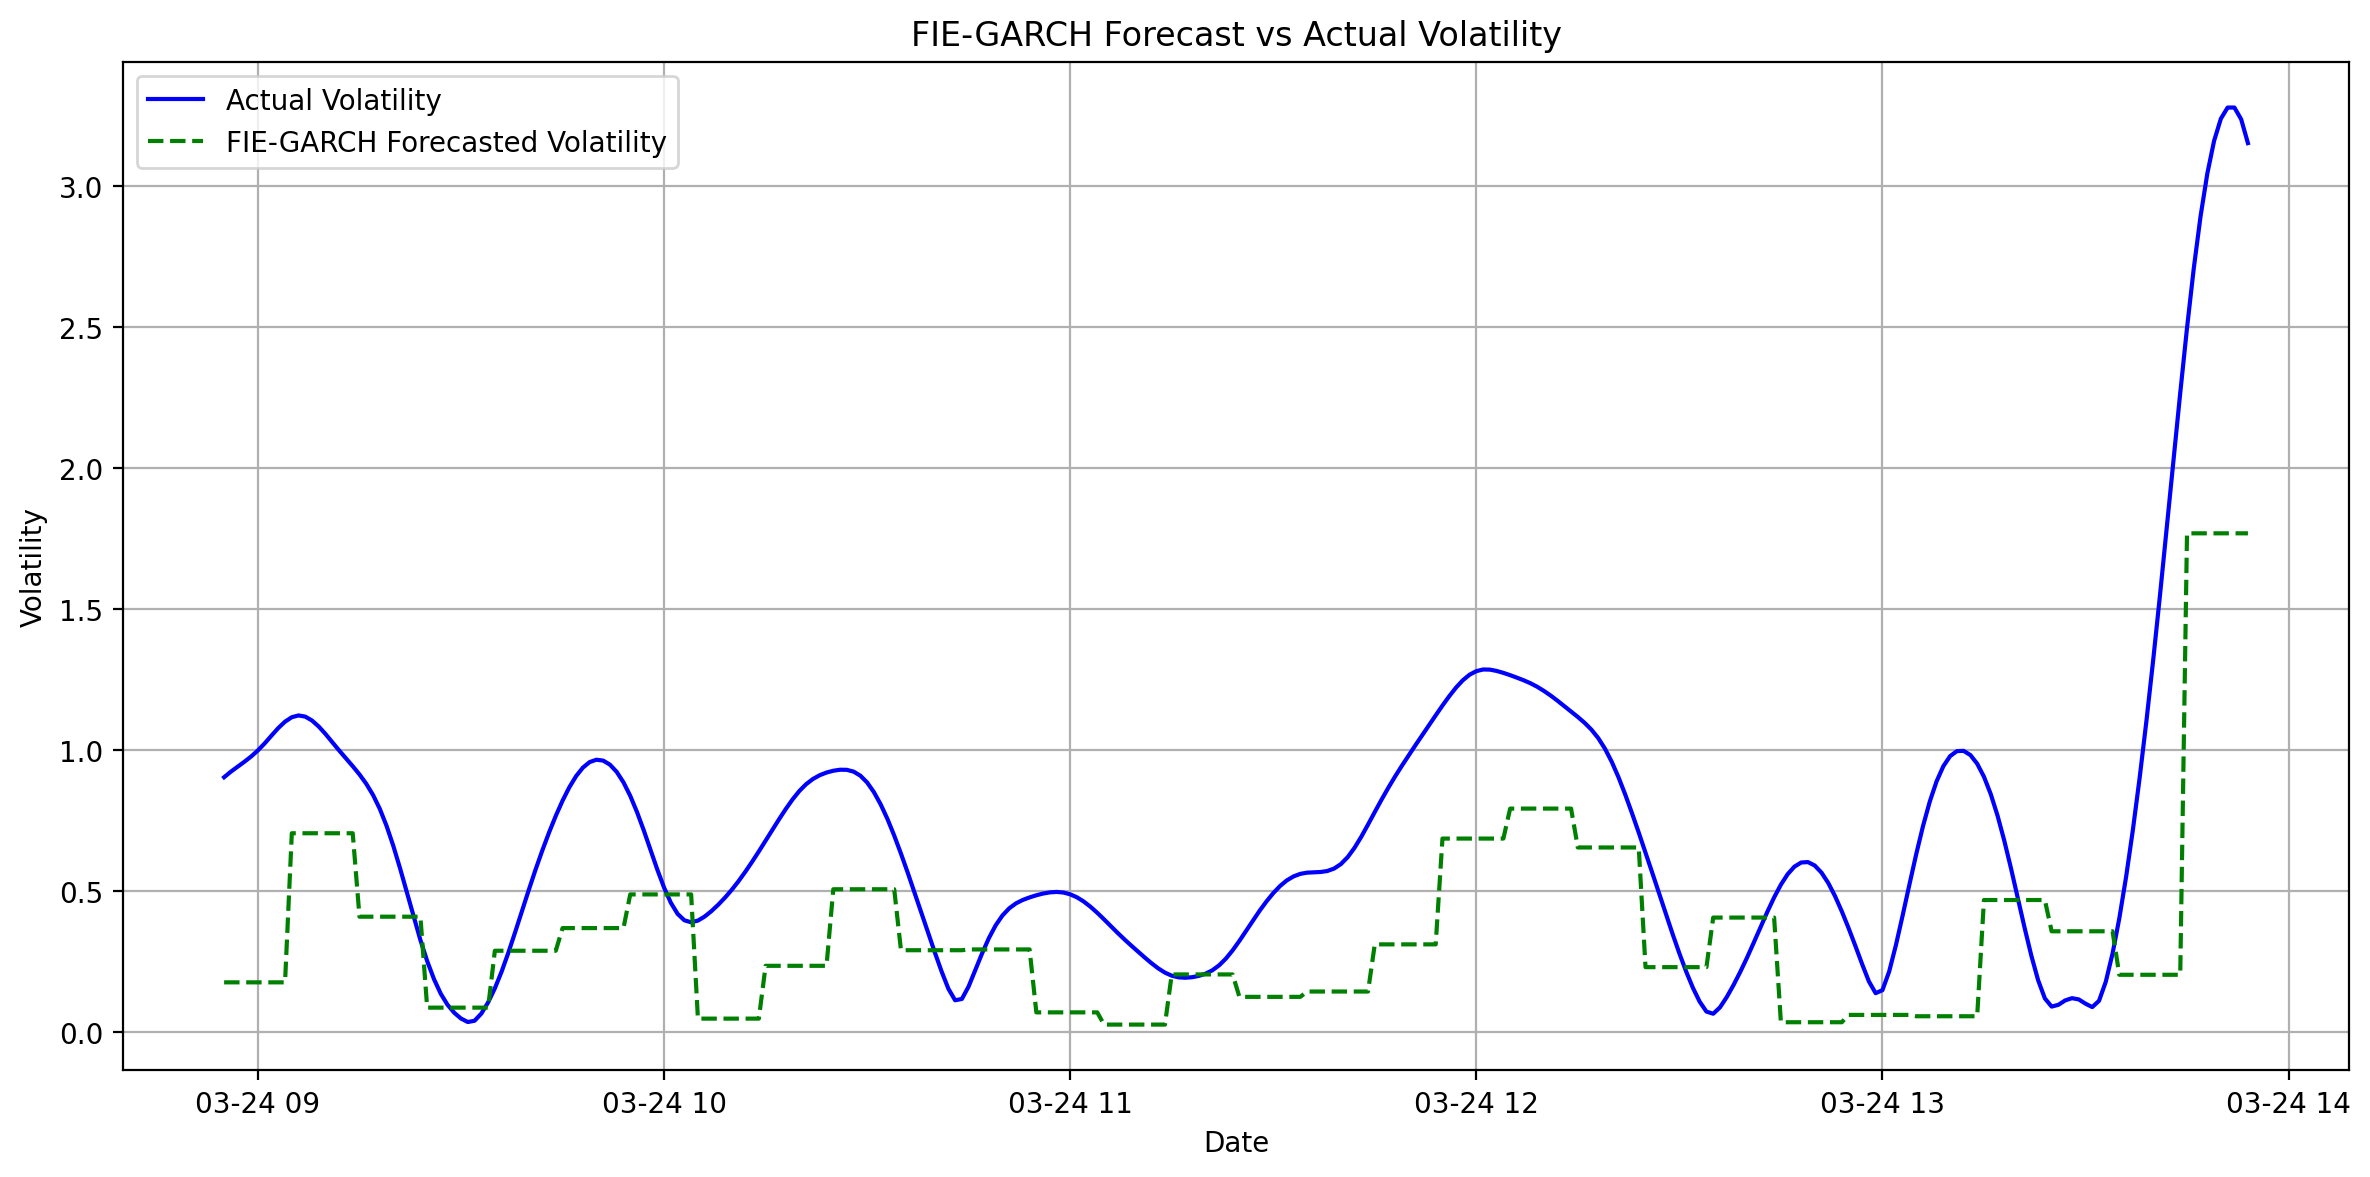

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

# --- Step 1: Clean & prepare data ---
ret_pandas = sp['realized_vol_D'].replace([np.inf, -np.inf], np.nan).dropna()
train_size = int(0.7 * len(ret_pandas))
train_data = ret_pandas[:train_size]
test_data = ret_pandas[train_size:]

# Scale data
scale = 1e4
train_data_scaled = train_data * scale
test_data_scaled = test_data * scale

# --- Settings ---
rolling_window_size = 250
refit_every = 10
num_simulations = 1
max_test_points = 300  # cut for speed during development

mae_list = []
rmse_list = []

# --- Step 2: Simulation Loop ---
for sim in tqdm(range(num_simulations), desc="Simulating FIE-GARCH Forecasting"):
    start_idx = np.random.randint(0, int(len(train_data_scaled) * 0.5))
    selected_chunk = train_data_scaled.iloc[start_idx:start_idx + rolling_window_size].copy()

    simulated_forecasted_vol = []
    simulated_actual_vol = []

    # Initial model fit
    model = arch_model(selected_chunk,
                       vol='FIGARCH', p=1, q=1,
                       mean='Constant', dist='normal')
    res = model.fit(disp='off')

    for i in range(min(len(test_data_scaled), max_test_points)):
        # Refit every `refit_every` steps
        if i % refit_every == 0:
            try:
                model = arch_model(selected_chunk, vol='FIGARCH', p=1, q=1,
                                   mean='Constant', dist='normal')
                res = model.fit(disp='off')
            except Exception:
                pass  # keep old model if fails

        try:
            forecast = res.forecast(horizon=1)
            fcast_var = forecast.variance.values[-1][0]
            fcast_vol = np.sqrt(fcast_var) / scale
        except:
            fcast_vol = selected_chunk.iloc[-1] / scale

        simulated_forecasted_vol.append(fcast_vol)
        actual_vol_point = test_data.iloc[i]
        simulated_actual_vol.append(actual_vol_point)

        # Update rolling window
        selected_chunk = pd.concat([selected_chunk, pd.Series(test_data_scaled.iloc[i])])
        if len(selected_chunk) > rolling_window_size:
            selected_chunk = selected_chunk[-rolling_window_size:]

    # --- Step 3: Evaluation ---
    mae = mean_absolute_error(simulated_actual_vol, simulated_forecasted_vol)
    rmse = np.sqrt(mean_squared_error(simulated_actual_vol, simulated_forecasted_vol))
    mae_list.append(mae)
    rmse_list.append(rmse)

# --- Step 4: Report Performance ---
print(f"\nMean MAE (FIE-GARCH): {np.mean(mae_list):.6f} ± {np.std(mae_list):.6f}")
print(f"Mean RMSE (FIE-GARCH): {np.mean(rmse_list):.6f} ± {np.std(rmse_list):.6f}")

# --- Step 5: Plotting One Simulation ---
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[:max_test_points], simulated_actual_vol, label='Actual Volatility', color='blue')
plt.plot(test_data.index[:max_test_points], simulated_forecasted_vol, label='FIE-GARCH Forecasted Volatility', color='green', linestyle='--')
plt.title('FIE-GARCH Forecast vs Actual Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the po


Mean Absolute Error (MAE): 0.626388
Root Mean Squared Error (RMSE): 1.051566


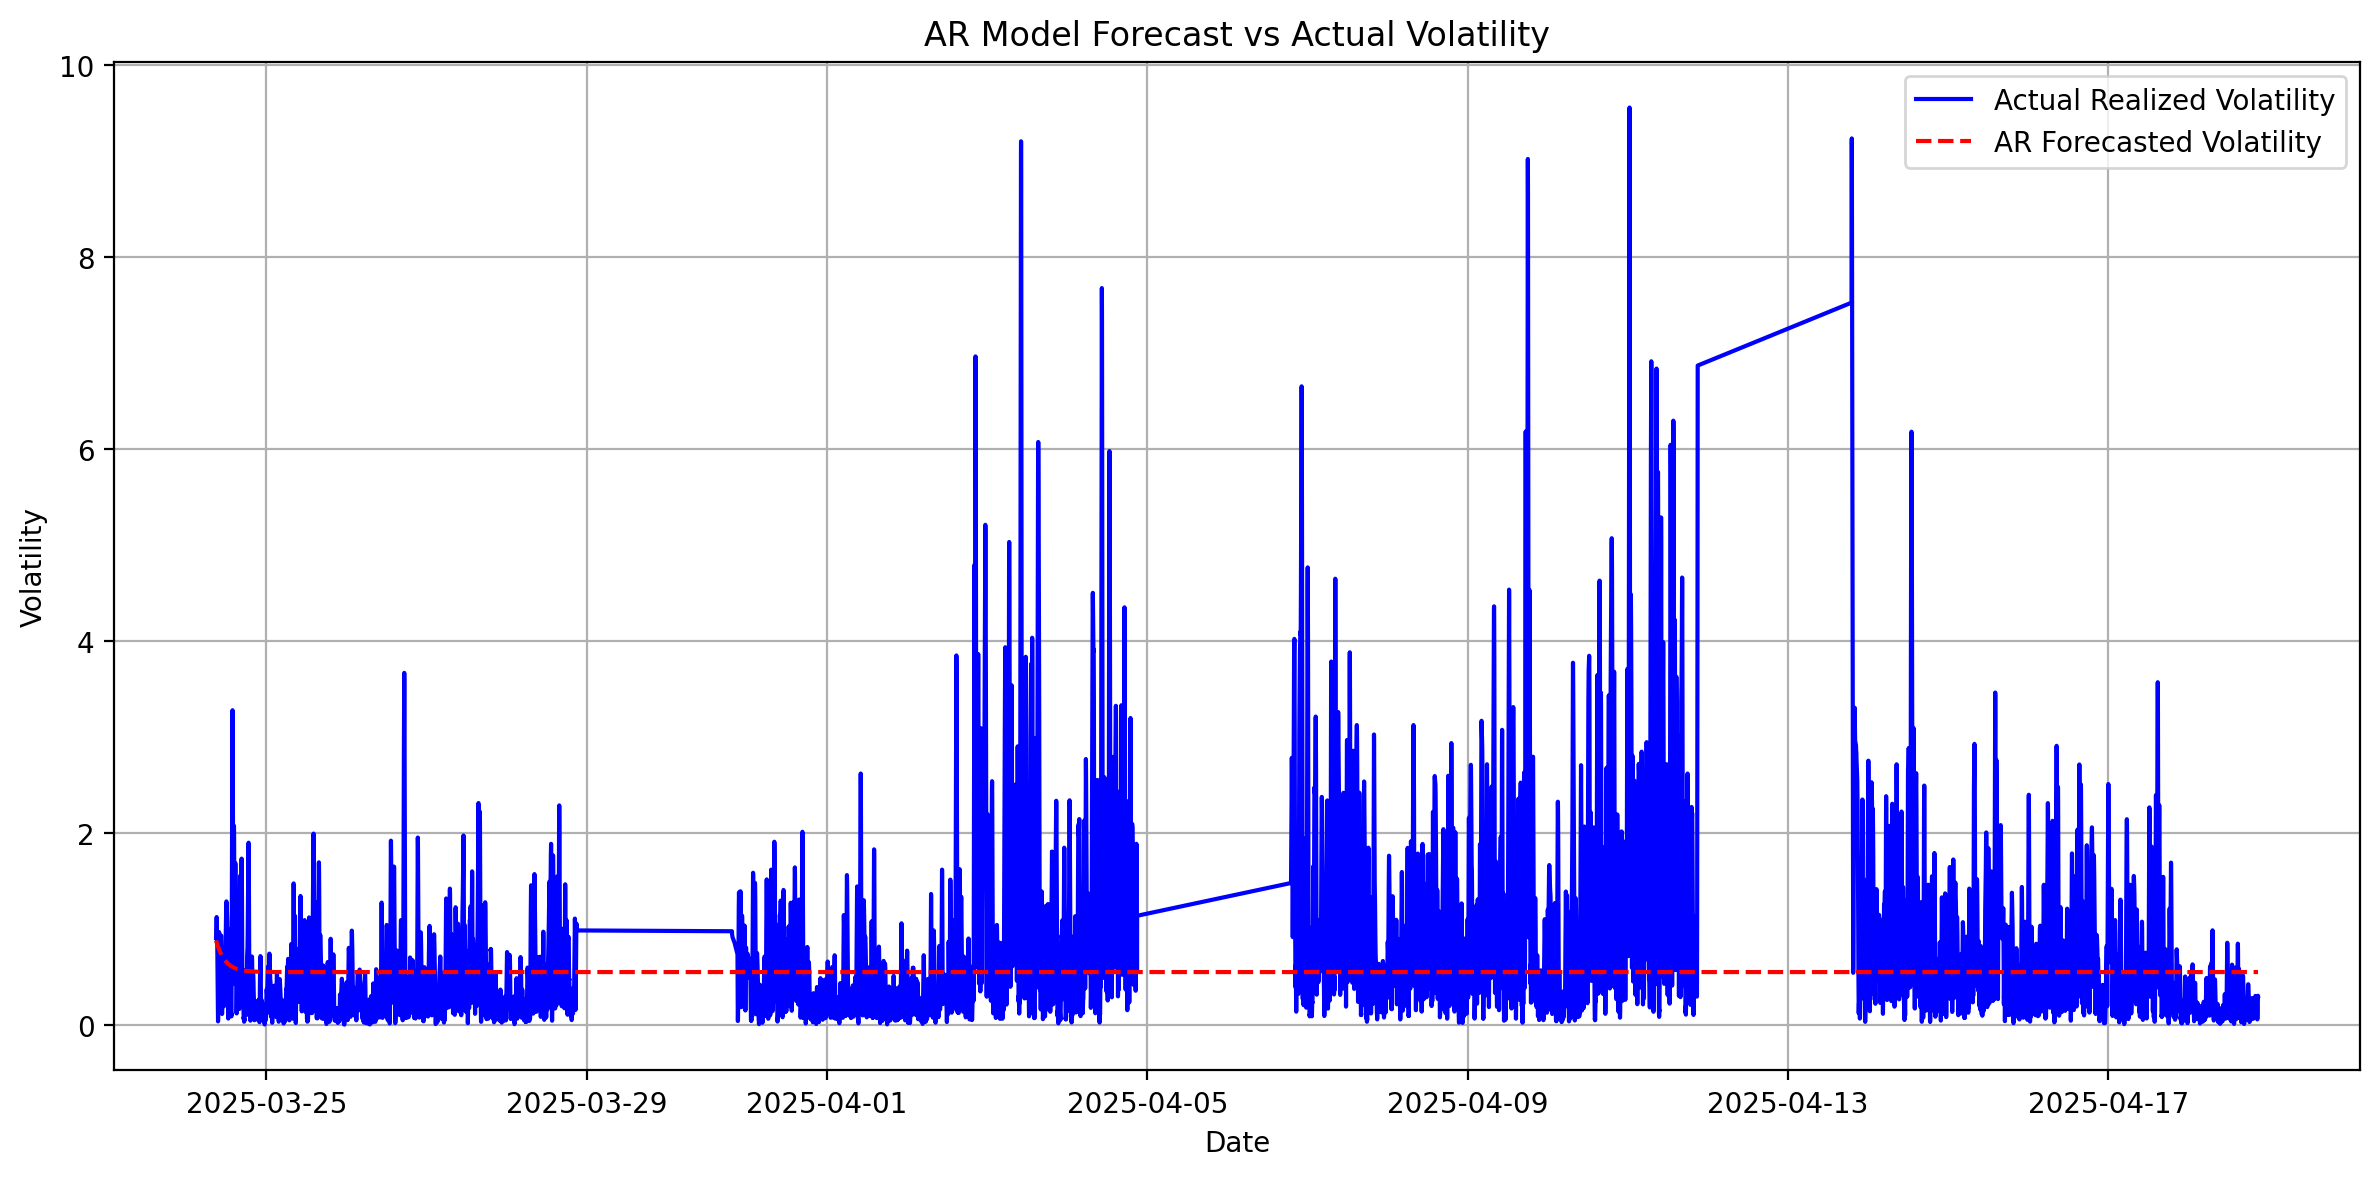

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Prepare Data ---
ret_pandas = sp['realized_vol_D'].replace([np.inf, -np.inf], np.nan).dropna()

train_size = int(len(ret_pandas) * 0.7)
train_data = ret_pandas[:train_size]
test_data = ret_pandas[train_size:]

# Fit AR model (no scaling)
model = AutoReg(train_data, lags=1)  # AR(1) model
res = model.fit()

# Forecast using the fitted AR model
forecasted_vol = res.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

# Compute error metrics
mae = mean_absolute_error(test_data, forecasted_vol)
rmse = np.sqrt(mean_squared_error(test_data, forecasted_vol))

print(f"\nMean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Realized Volatility', color='blue')
plt.plot(test_data.index, forecasted_vol, label='AR Forecasted Volatility', color='red', linestyle='--')
plt.title('AR Model Forecast vs Actual Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [48]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from arch import arch_model
from statsmodels.tsa.ar_model import AutoReg
from arch.__future__ import reindexing  # future-proof indexing

# Load your data
# Replace this line with the actual loading method for your data
# Example: sp = pd.read_csv("your_data.csv", parse_dates=True, index_col='Date')
realized_vol = sp['realized_vol_D'].dropna()
y = realized_vol.copy()
n_train = int(len(y) * 0.998)

In [49]:
# EWMA Volatility
def ewma_volatility(series, lambda_=0.94):
    ewma = []
    prev = series.var()
    for r in series:
        var = lambda_ * prev + (1 - lambda_) * r**2
        ewma.append(np.sqrt(var))
        prev = var
    return pd.Series(ewma, index=series.index)

# Containers for forecasts
rv_ewma = []
rv_gjr_garch = []
rv_aparch = []
rv_figarch = []
rv_arrv = []


In [ ]:
for i in tqdm(range(n_train, len(y)), desc="Rolling Forecast"):
    train = y[:i]

    # EWMA
    try:
        ewma = ewma_volatility(train)
        rv_ewma.append(ewma.iloc[-1])
    except:
        rv_ewma.append(np.nan)

    # GJR-GARCH(1,1,1)
    try:
        gjr = arch_model(train, vol='GARCH', p=1, o=1, q=1, dist='normal')
        res_gjr = gjr.fit(disp='off')
        forecast = res_gjr.forecast(horizon=1).variance.values[-1, 0]
        rv_gjr_garch.append(np.sqrt(forecast))
    except:
        rv_gjr_garch.append(np.nan)

    # APARCH(1,1)
    try:
        aparch = arch_model(train, vol='APARCH', p=1, q=1, dist='normal')
        res_aparch = aparch.fit(disp='off')
        forecast = res_aparch.forecast(horizon=1).variance.values[-1, 0]
        rv_aparch.append(np.sqrt(forecast))
    except:
        rv_aparch.append(np.nan)

    # FIGARCH(1,d,1)
    try:
        figarch = arch_model(train, vol='FIGARCH', p=1, q=1, dist='normal')
        res_figarch = figarch.fit(disp='off')
        forecast = res_figarch.forecast(horizon=1).variance.values[-1, 0]
        rv_figarch.append(np.sqrt(forecast))
    except:
        rv_figarch.append(np.nan)

    # AR-RV
    try:
        ar_model = AutoReg(train, lags=1).fit()
        forecast = ar_model.predict(start=len(train), end=len(train))
        rv_arrv.append(float(forecast))
    except:
        rv_arrv.append(np.nan)




Rolling Forecast:   0%|          | 0/188 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `

In [ ]:
# Create DataFrame
forecast_index = y.index[n_train:]
df_results = pd.DataFrame({
    'actual': y[n_train:].values,
    'EWMA': rv_ewma,
    'GJR-GARCH': rv_gjr_garch,
    'APARCH': rv_aparch,
    'FIGARCH': rv_figarch,
    'AR-RV': rv_arrv
}, index=forecast_index)

# R² OS Function
def r2_os(y_true, y_pred, benchmark):
    num = np.sum((y_true - y_pred)**2)
    denom = np.sum((y_true - benchmark)**2)
    return 1 - num / denom

# Benchmark = Historical mean of training set
benchmark = np.mean(y[:n_train])

# R² OS Outputs
print("R² OS (EWMA):", r2_os(df_results['actual'], df_results['EWMA'], benchmark))
print("R² OS (GJR-GARCH):", r2_os(df_results['actual'], df_results['GJR-GARCH'], benchmark))
print("R² OS (APARCH):", r2_os(df_results['actual'], df_results['APARCH'], benchmark))
print("R² OS (FIGARCH):", r2_os(df_results['actual'], df_results['FIGARCH'], benchmark))
print("R² OS (AR-RV):", r2_os(df_results['actual'], df_results['AR-RV'], benchmark))


In [ ]:
import matplotlib.pyplot as plt

plt.style.use('classic')  # or try 'ggplot', 'bmh', 'fivethirtyeight'

plt.figure(figsize=(14, 8))

# Plot actual vs forecasts
plt.plot(df_results.index, df_results['actual'], label='Actual Realized Volatility', linewidth=2, color='black')
plt.plot(df_results.index, df_results['EWMA'], label='EWMA', linestyle='--')
plt.plot(df_results.index, df_results['GJR-GARCH'], label='GJR-GARCH(1,1,1)', linestyle='--')
plt.plot(df_results.index, df_results['APARCH'], label='APARCH(1,1)', linestyle='--')
plt.plot(df_results.index, df_results['FIGARCH'], label='FIGARCH(1,d,1)', linestyle='--')
plt.plot(df_results.index, df_results['AR-RV'], label='AR-RV(1)', linestyle='--')

# Final plot settings
plt.title('Out-of-Sample Volatility Forecasts vs Realized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import statsmodels.api as sm
import pandas as pd

def run_regression(y, X, label):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(f"\n--- Regression for {label} ---")
    print(model.summary())
    return model

# Convert forecast lists to pandas Series with proper indexing
index = y[n_train:].index  # ensure alignment with actual values

df_results = pd.DataFrame({
    'actual': y[n_train:].values,
    'EWMA': pd.Series(rv_ewma, index=index),
    'GJR-GARCH': pd.Series(rv_gjr_garch, index=index),
    'APARCH': pd.Series(rv_aparch, index=index),
    'FIGARCH': pd.Series(rv_figarch, index=index),
    'AR-RV': pd.Series(rv_arrv, index=index)
}, index=index)

# Rename columns for regression
df_reg = df_results.rename(columns={
    'actual': 'RV_Actual',
    'EWMA': 'RV_EWMA',
    'GJR-GARCH': 'RV_GARCH',
    'APARCH': 'RV_APARCH',
    'FIGARCH': 'RV_FIGARCH',
    'AR-RV': 'RV_ARRV'
})

# Drop any rows with NaNs
df_reg_clean = df_reg.dropna()

# Run individual regressions
run_regression(df_reg_clean['RV_Actual'], df_reg_clean['RV_EWMA'], 'EWMA')
run_regression(df_reg_clean['RV_Actual'], df_reg_clean['RV_GARCH'], 'GARCH')
run_regression(df_reg_clean['RV_Actual'], df_reg_clean['RV_APARCH'], 'APARCH')
run_regression(df_reg_clean['RV_Actual'], df_reg_clean['RV_FIGARCH'], 'FIGARCH')
run_regression(df_reg_clean['RV_Actual'], df_reg_clean['RV_ARRV'], 'ARRV')

# Run joint regression
run_regression(
    df_reg_clean['RV_Actual'],
    df_reg_clean[['RV_EWMA', 'RV_GARCH', 'RV_APARCH', 'RV_FIGARCH', 'RV_ARRV']],
    'All Models'
)
